<a href="https://colab.research.google.com/github/DexterYTgaming/Stock-reg-model/blob/main/stock_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import csv
import os
import sklearn 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, silhouette_score
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures
# clustering
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.spatial.distance import dist
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.cluster import KMeans 
import itertools
from matplotlib import gridspec
from sklearn.cluster import cluster_optics_dbscan

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10,8]

In [ ]:
# read all the data
df_index = pd.read_csv('indexData.csv')
df_info =pd.read_csv('indexInfo.csv')
df_processed = pd.read_csv('indexProcessed.csv')

In [ ]:
df_processed.tail(3)

Index        Date         Open         High          Low  \
104221  J203.JO  2021-05-27  66108.22656  66940.25000  66102.54688   
104222  J203.JO  2021-05-28  66940.25000  67726.56250  66794.60938   
104223  J203.JO  2021-05-31  67554.85938  68140.85156  67554.85938   

              Close    Adj Close  Volume     CloseUSD  
104221  66940.25000  66940.25000     0.0  4685.817500  
104222  67554.85938  67554.85938     0.0  4728.840157  
104223  67964.03906  67964.03906     0.0  4757.482734

In [ ]:
df_index.tail(3)  

Index        Date         Open         High          Low        Close  \
112454  N100  2021-05-31  1256.079956  1258.880005  1248.140015  1248.930054   
112455  N100  2021-06-01  1254.609985  1265.660034  1254.609985  1258.579956   
112456  N100  2021-06-02  1258.489990  1263.709961  1258.239990  1263.619995   

          Adj Close       Volume  
112454  1248.930054   91173700.0  
112455  1258.579956  155179900.0  
112456  1263.619995  148465000.0

In [ ]:
df_info

Region                          Exchange      Index Currency
0   United States           New York Stock Exchange        NYA      USD
1   United States                            NASDAQ       IXIC      USD
2       Hong Kong          Hong Kong Stock Exchange        HSI      HKD
3           China           Shanghai Stock Exchange  000001.SS      CNY
4           Japan              Tokyo Stock Exchange       N225      JPY
5          Europe                          Euronext       N100      EUR
6           China           Shenzhen Stock Exchange  399001.SZ      CNY
7          Canada            Toronto Stock Exchange     GSPTSE      CAD
8           India  National Stock Exchange of India       NSEI      INR
9         Germany          Frankfurt Stock Exchange      GDAXI      EUR
10          Korea                    Korea Exchange       KS11      KRW
11    Switzerland                SIX Swiss Exchange       SSMI      CHF
12         Taiwan             Taiwan Stock Exchange       TWII      TWD
13   South Africa       Johannesburg Stock Exchange    J203.JO      ZAR

In [ ]:
# merging df_processed and df_info
df_merged = df_processed.merge(df_info, how='outer', on='Index')
df_merged.head(3)

Index        Date         Open         High          Low        Close  \
0   HSI  1986-12-31  2568.300049  2568.300049  2568.300049  2568.300049   
1   HSI  1987-01-02  2540.100098  2540.100098  2540.100098  2540.100098   
2   HSI  1987-01-05  2552.399902  2552.399902  2552.399902  2552.399902   

     Adj Close  Volume    CloseUSD     Region                  Exchange  \
0  2568.300049     0.0  333.879006  Hong Kong  Hong Kong Stock Exchange   
1  2540.100098     0.0  330.213013  Hong Kong  Hong Kong Stock Exchange   
2  2552.399902     0.0  331.811987  Hong Kong  Hong Kong Stock Exchange   

  Currency  
0      HKD  
1      HKD  
2      HKD

In [ ]:
df_merged.Index.unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO', 'KS11'],
      dtype=object)

In [ ]:
# converting the date column a pd datetime column and setting it as the index
df_merged['Date'] = pd.to_datetime(df_merged['Date'])
df_merged.set_index('Date', inplace=True)

In [ ]:
# dropping na values
df = df_merged.dropna()
df.shape

(104224, 11)

In [ ]:
print(list(df.Index.unique()))

['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ', 'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO']


In [ ]:
# Function to plot charts

def EDA_plots(df,stexch):
    
    data = df.loc[df['Index']== stexch]
        
    plt.title('Cumulative Returns of {}'.format(stexch), size = 20, y = 1.03, fontname = 'monospace')
   
    # Cumulative returns
    ( (data['CloseUSD'].pct_change()+1).cumprod() ).plot( figsize=(20,5) )

    fig, ax = plt.subplots(1,3, figsize=(18,6), tight_layout=True)
    
    ax[0].set_title('Change in Open price of {}'.format(stexch), fontsize=11  )
    data['Open'].plot(label=stexch, ax=ax[0], alpha=0.5, fontsize=10 )
    ax[0].set_ylabel('Open Price')
    ax[0].grid(which='major', linestyle='-.', linewidth='0.5', color='black')
    
    ax[1].set_title('Change in Close price of {}'.format(stexch), fontsize=11 )
    data['Close'].plot(label=stexch, ax=ax[1], alpha=0.5, fontsize=10)
    ax[1].set_ylabel('Close Price')
    ax[1].grid(which='major', linestyle=':', linewidth='0.5', color='black')
    
    ax[2].set_title('Trading Volume price of {}'.format(stexch), fontsize=11 )
    data['Volume'].plot(label=stexch, ax=ax[2], alpha=0.5, fontsize=10)
    ax[2].set_ylabel('Volume')
    ax[2].grid(which='major', linestyle=':', linewidth='0.5', color='black')
    
    plt.show()


# Define hyper parameter ratios
    
def ratios(df,exch):
    # cumulative returns for each exchange
    data = df.copy()
    ratiodf = data.loc[data['Index']==exch]
    ratiodf['Daily returns'] = ratiodf['Close'].pct_change()
    ratiodf['Cumulative returns'] = (1 + ratiodf['Daily returns']).cumprod()
    
    trading_days = 252 # no. of trading days in a year
    n = len(data) /trading_days
    
    # calculate cumulative reurns
    # CAGR -> compound annual growth rate
    # CAGR = ((End_value / Beginning_value)**1/n  - 1 ) * 100
    cagr = ( ( ratiodf['Cumulative returns'][-1]**(1/n) ) - 1 ) * 100
    
    # calculate annualized volatility
    vol = ratiodf['Daily returns'].std() * np.sqrt(trading_days)
    
    
    return cagr, vol


    

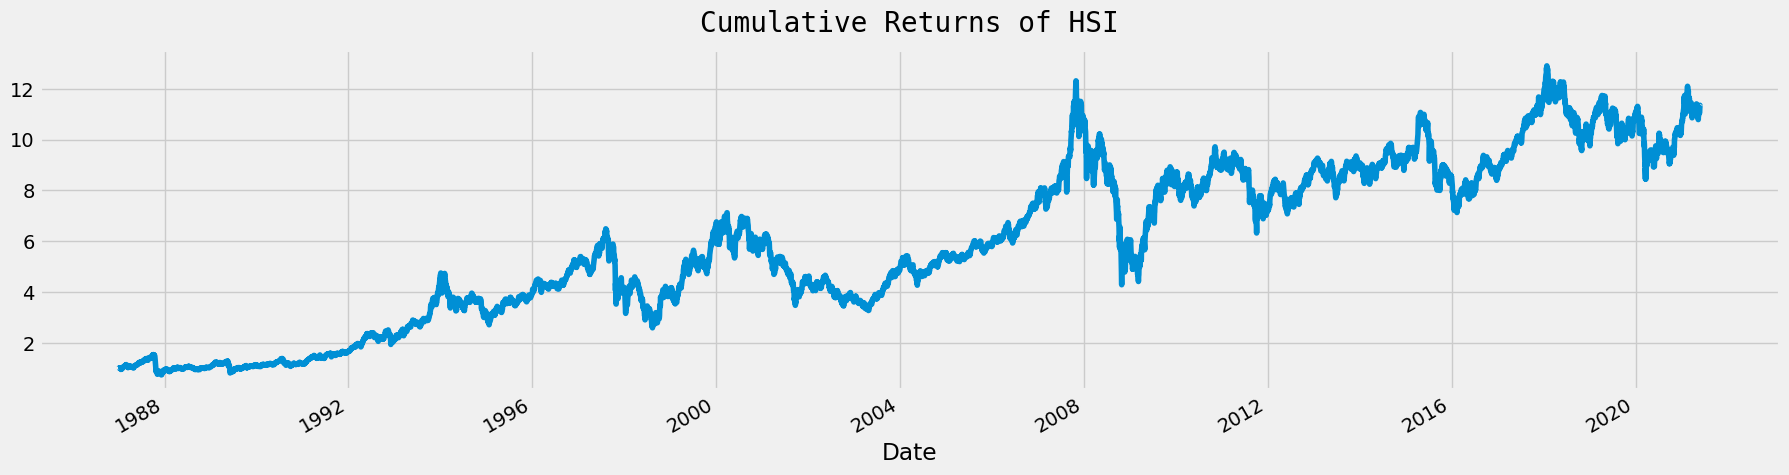

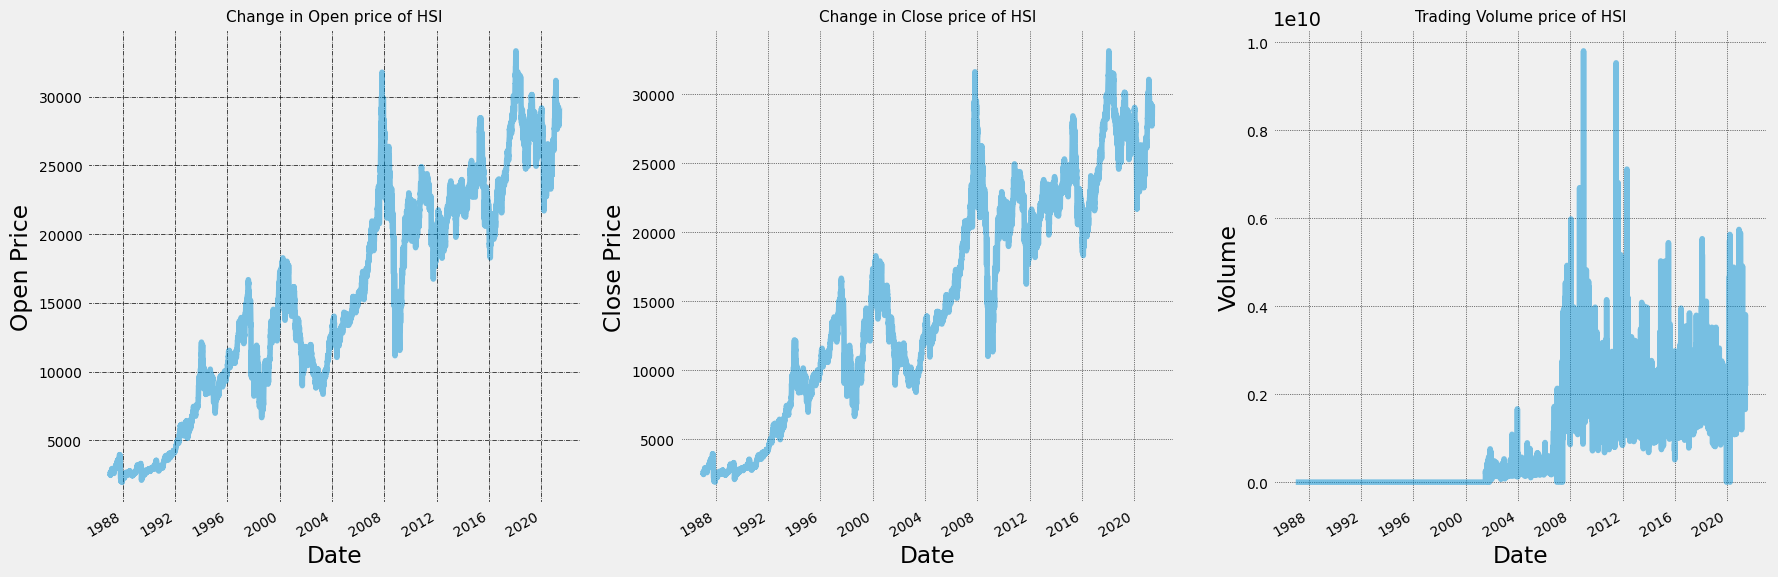

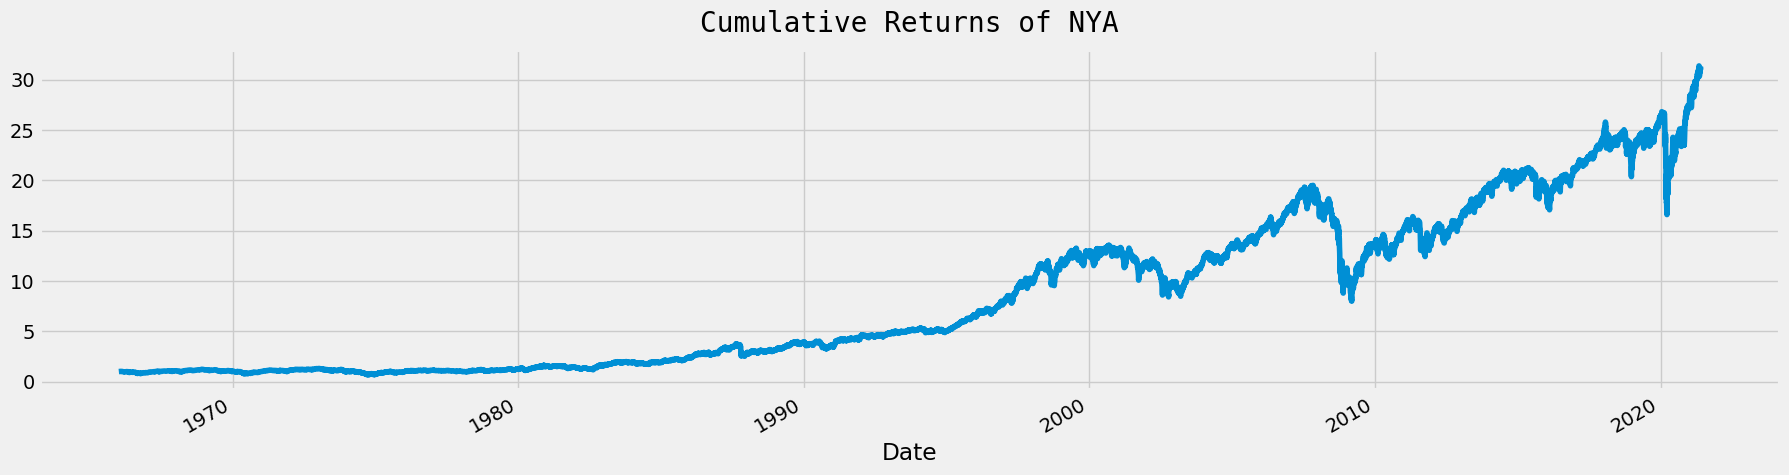

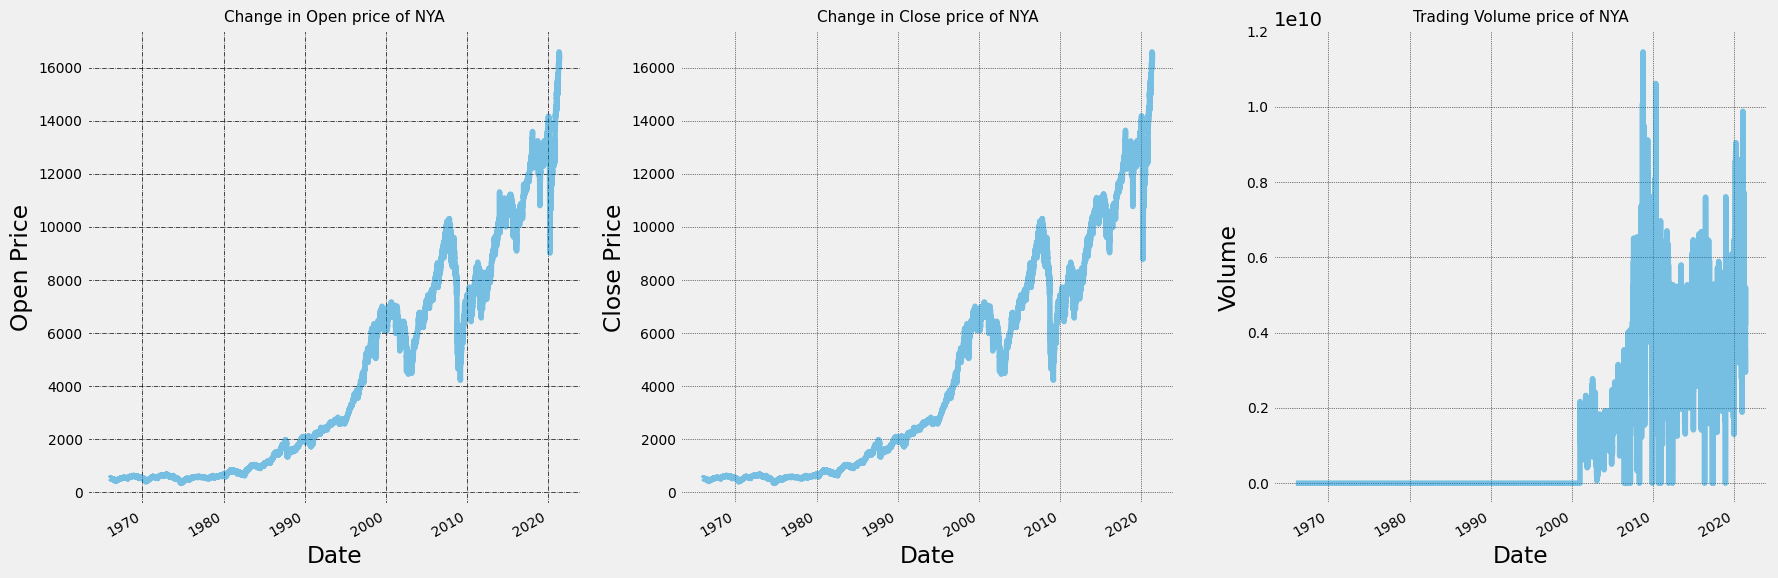

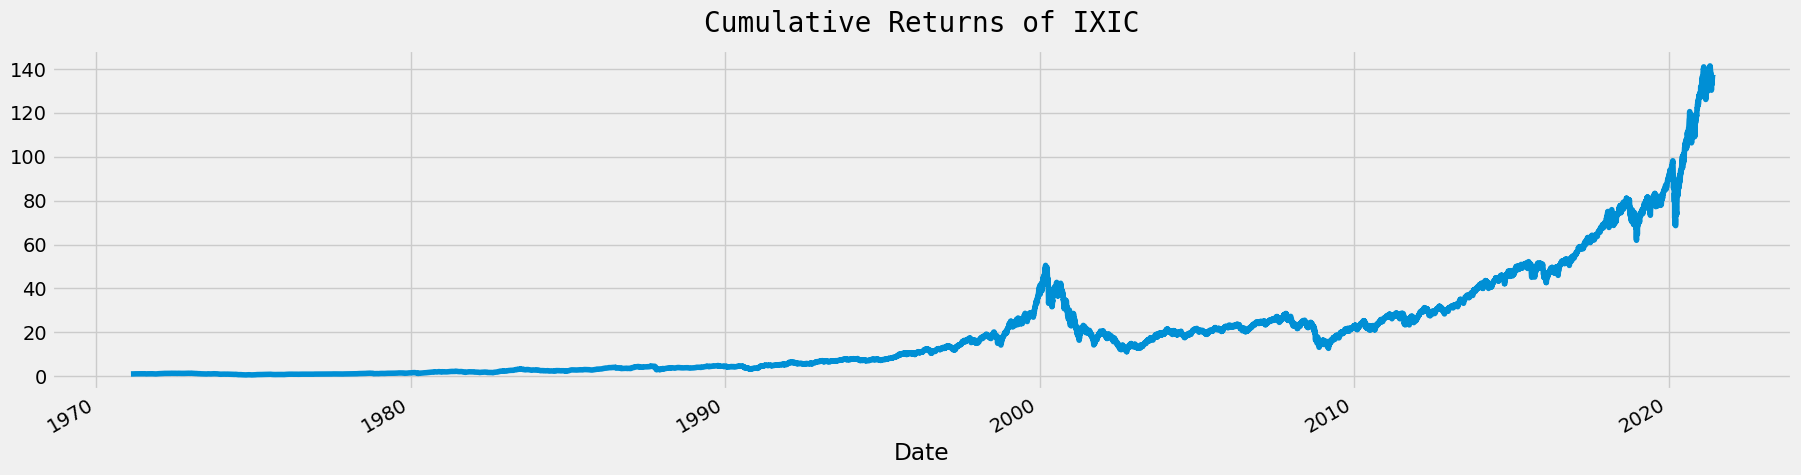

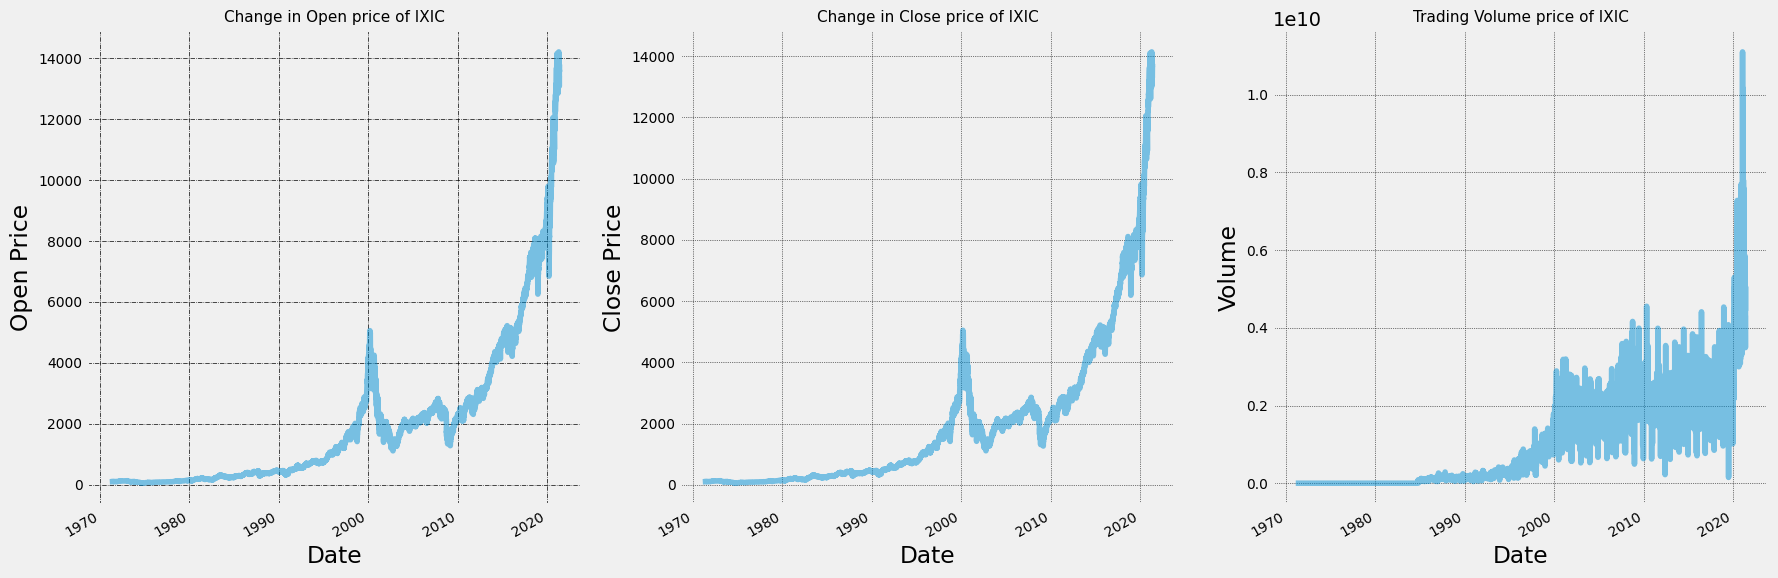

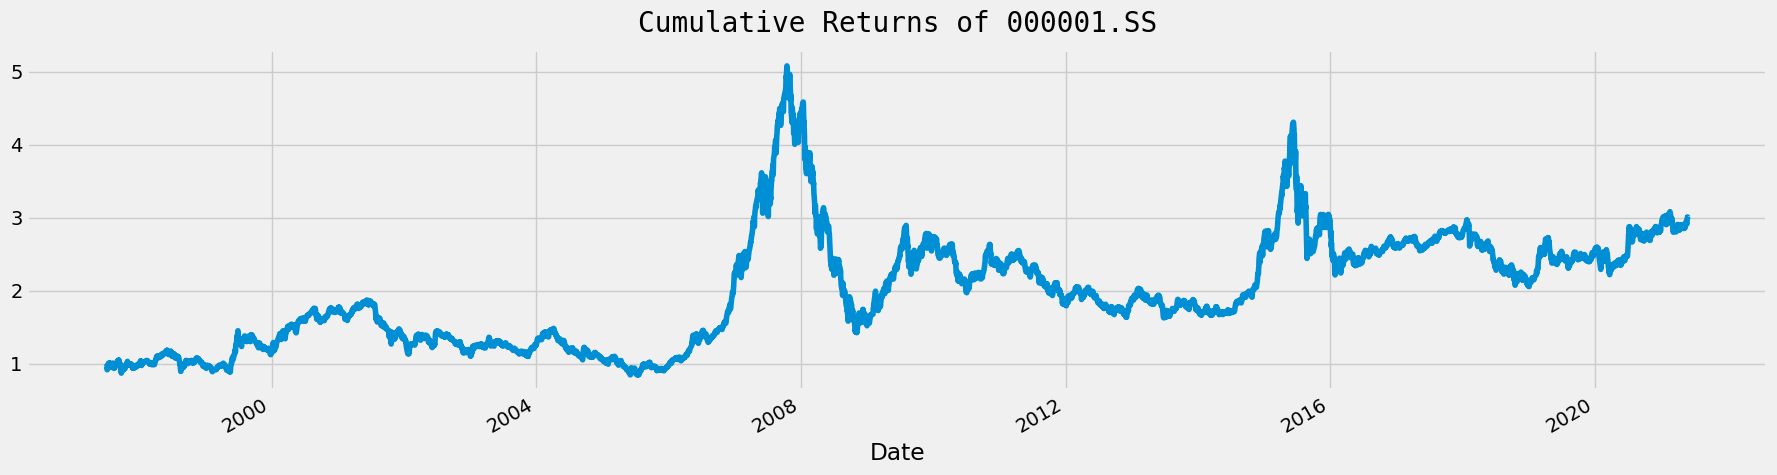

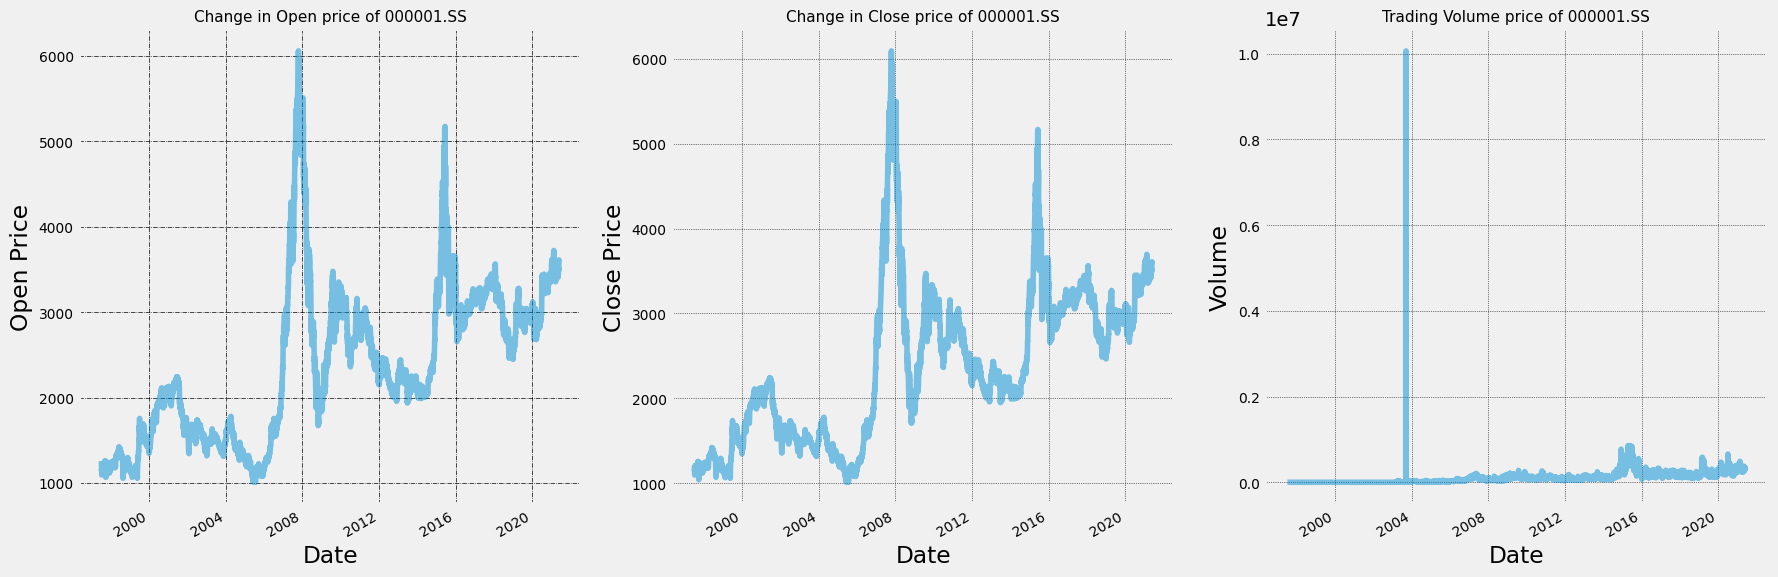

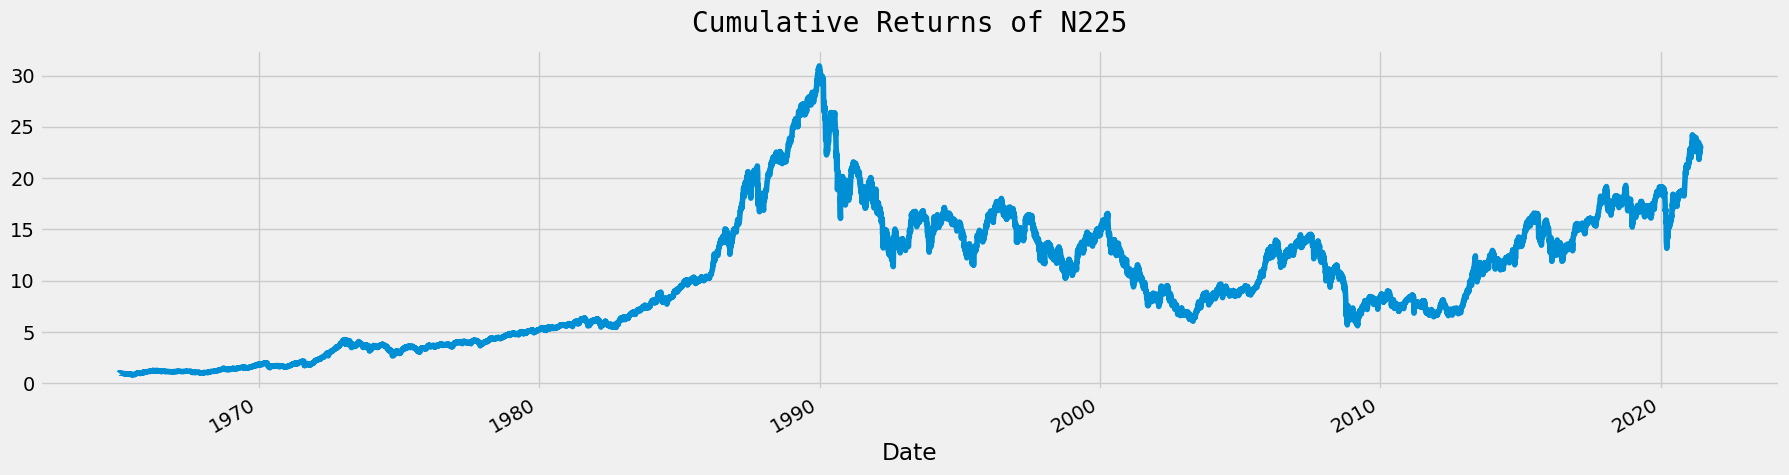

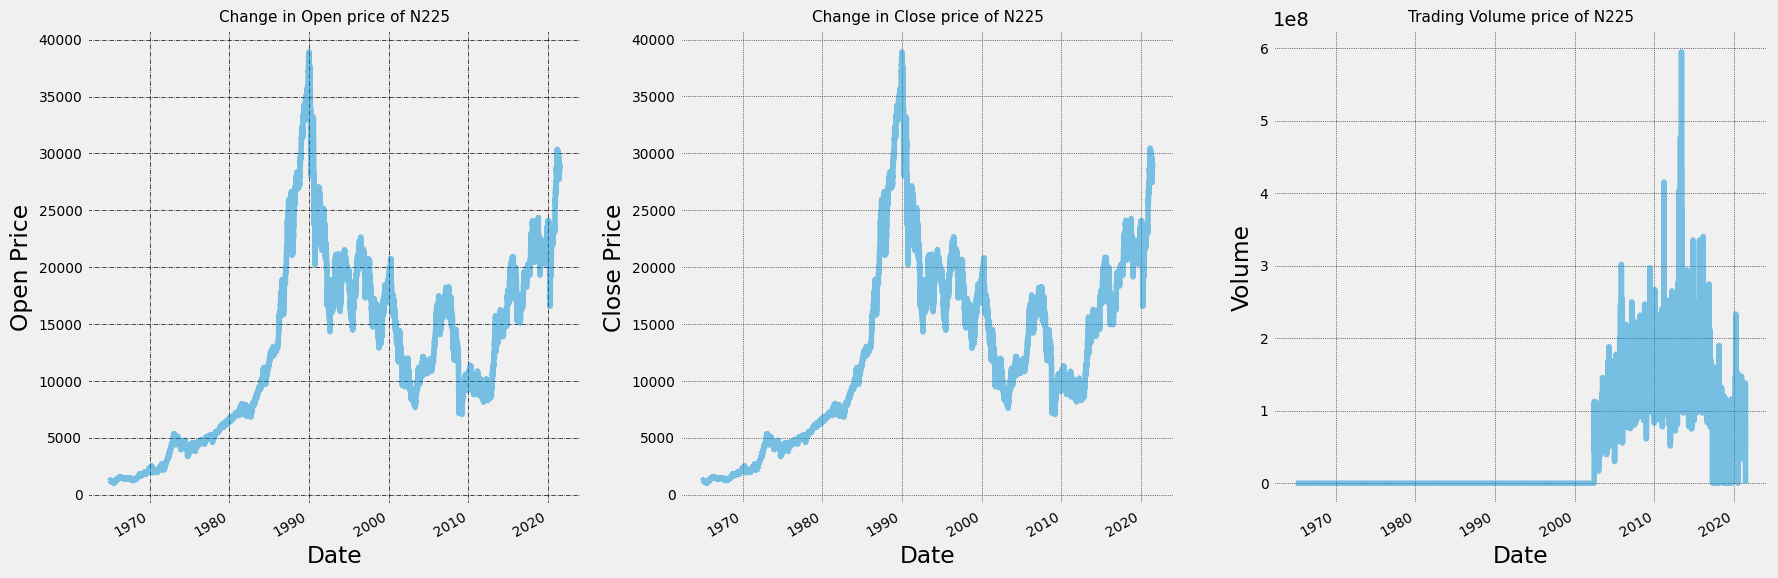

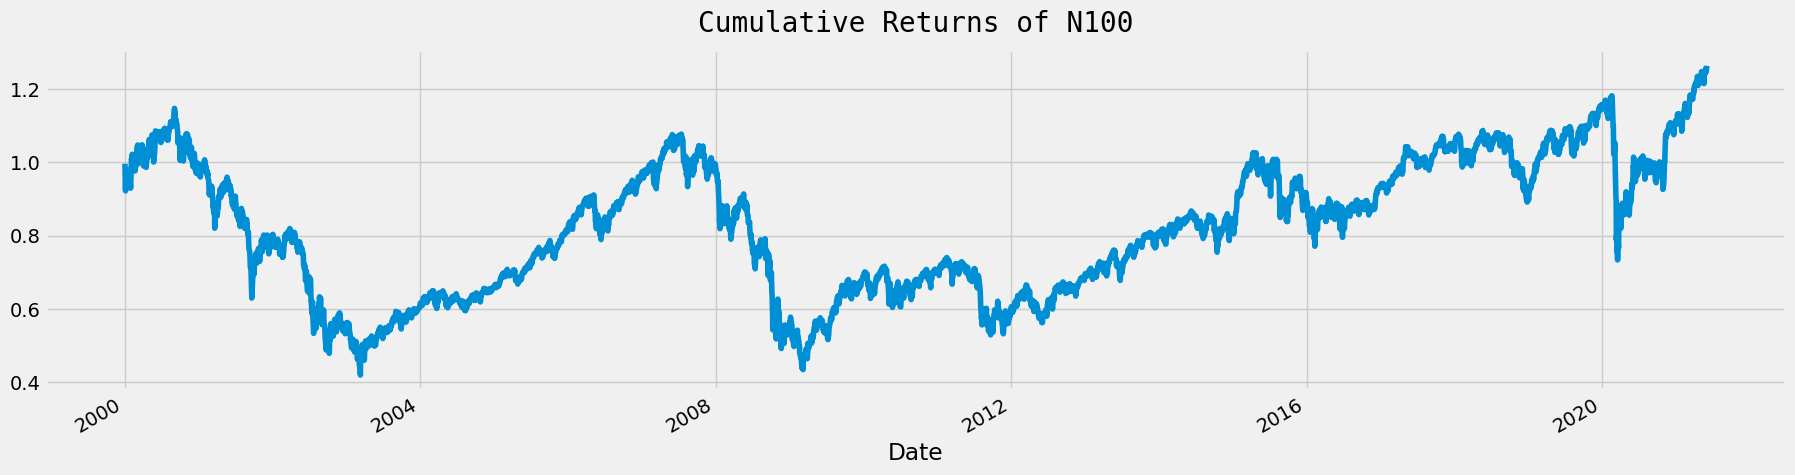

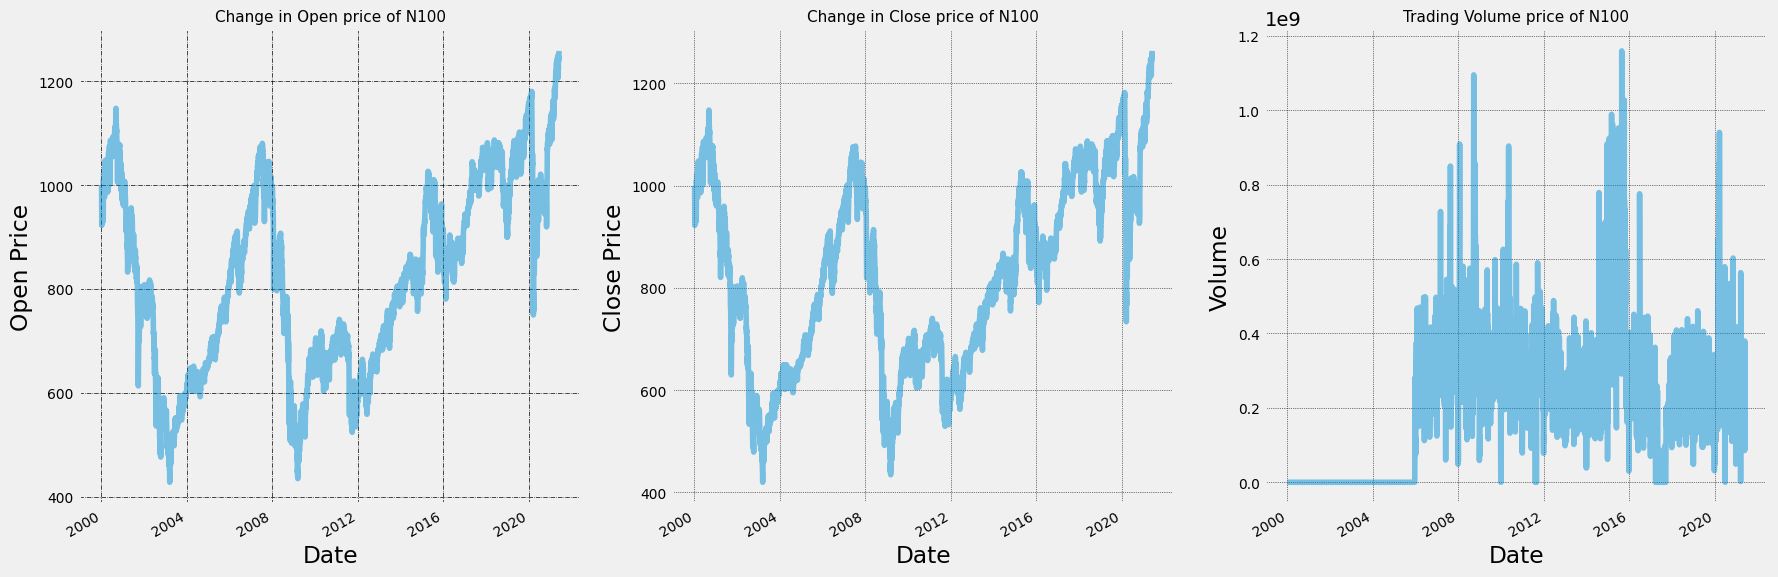

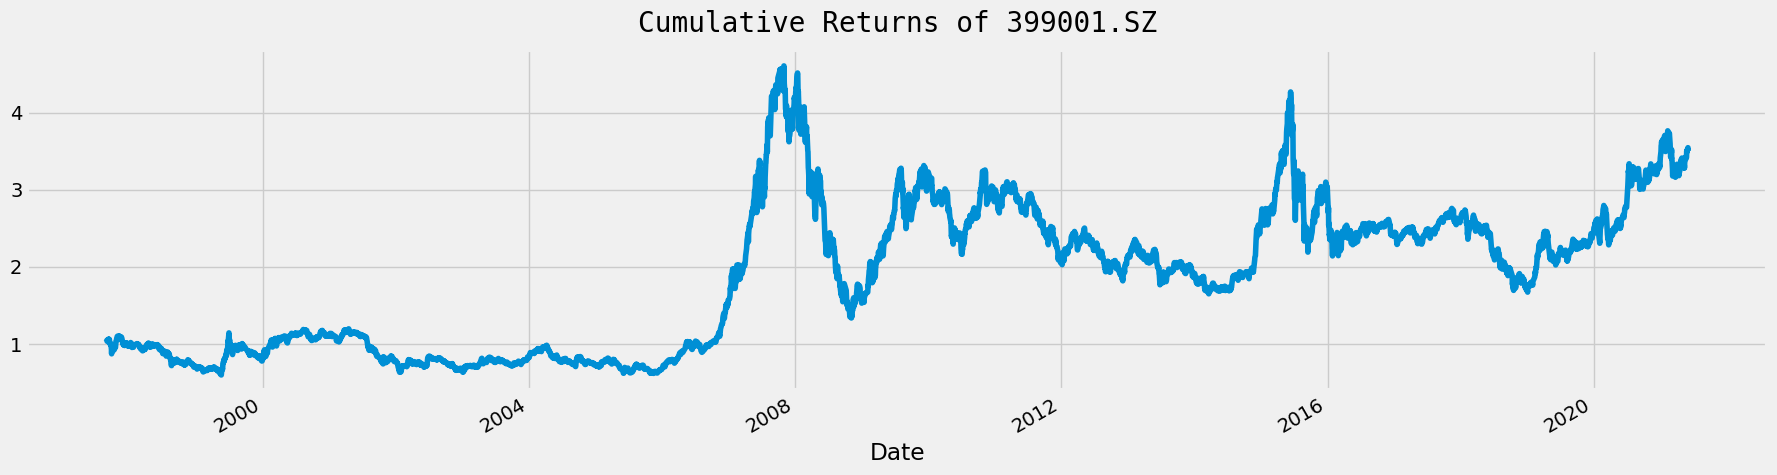

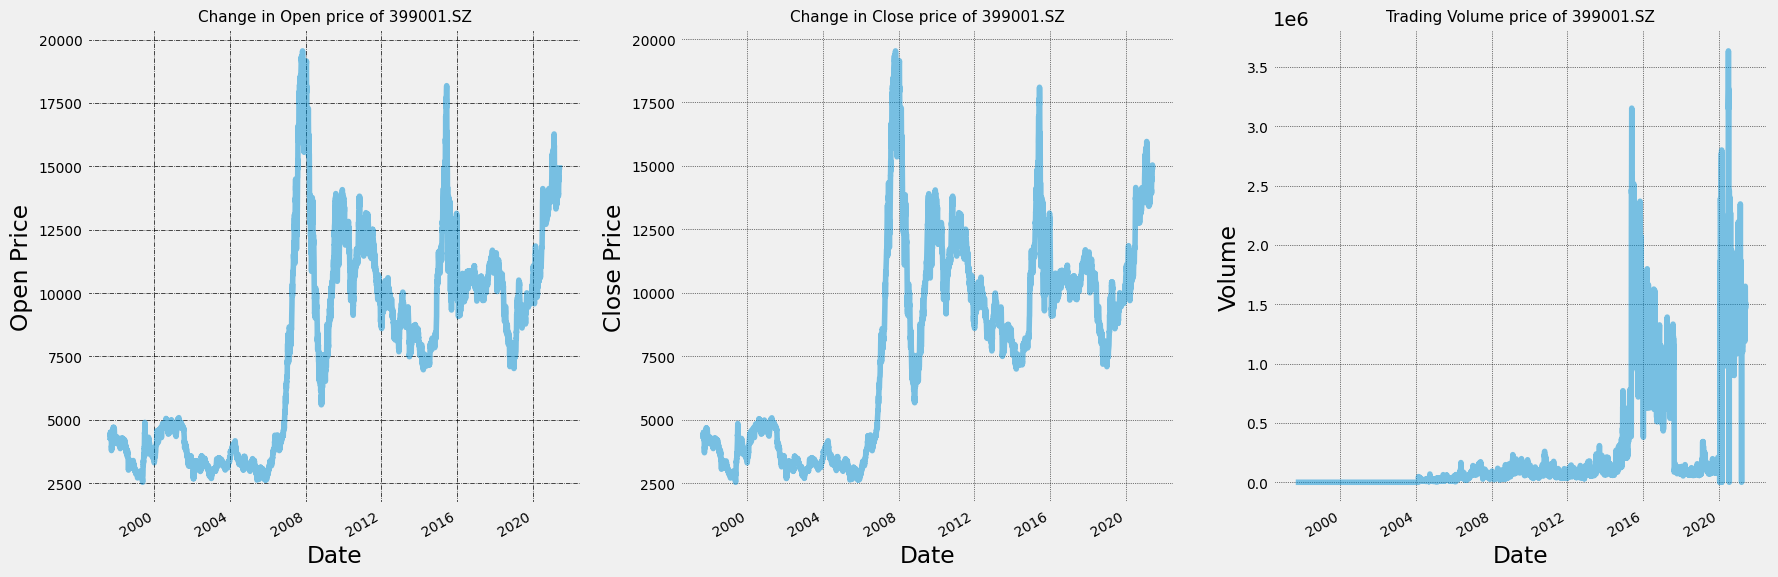

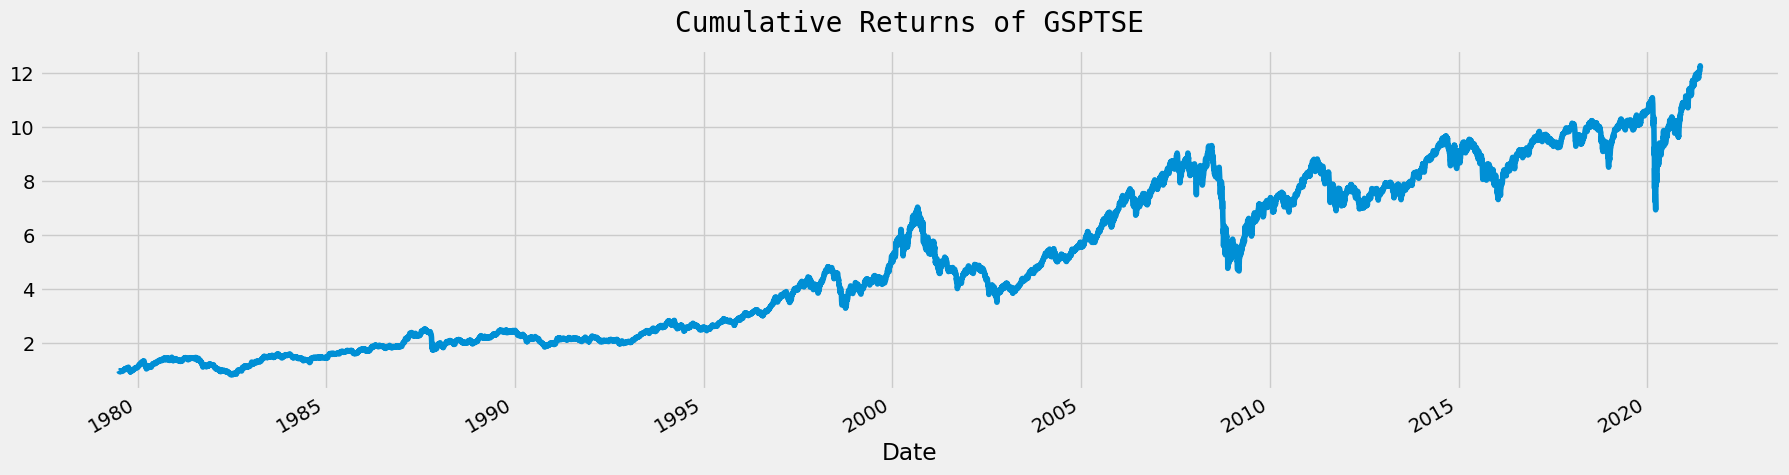

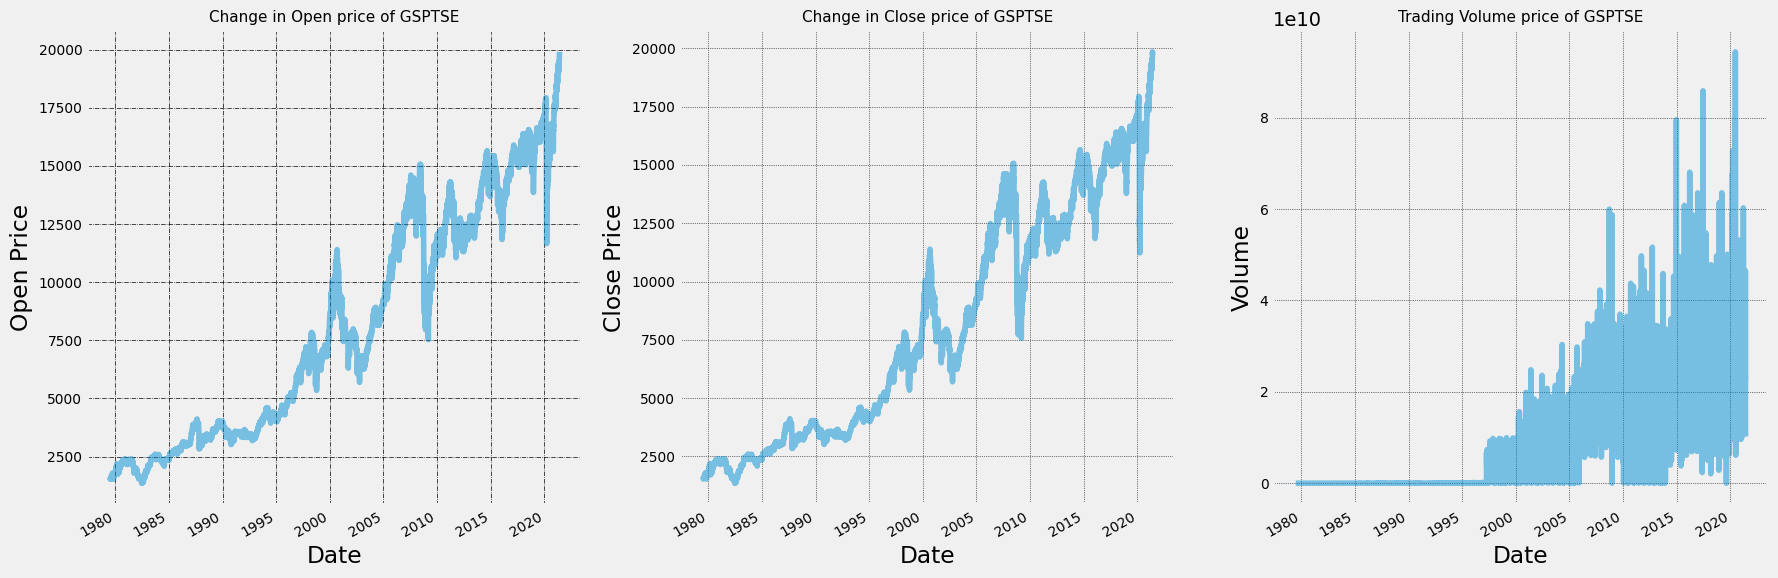

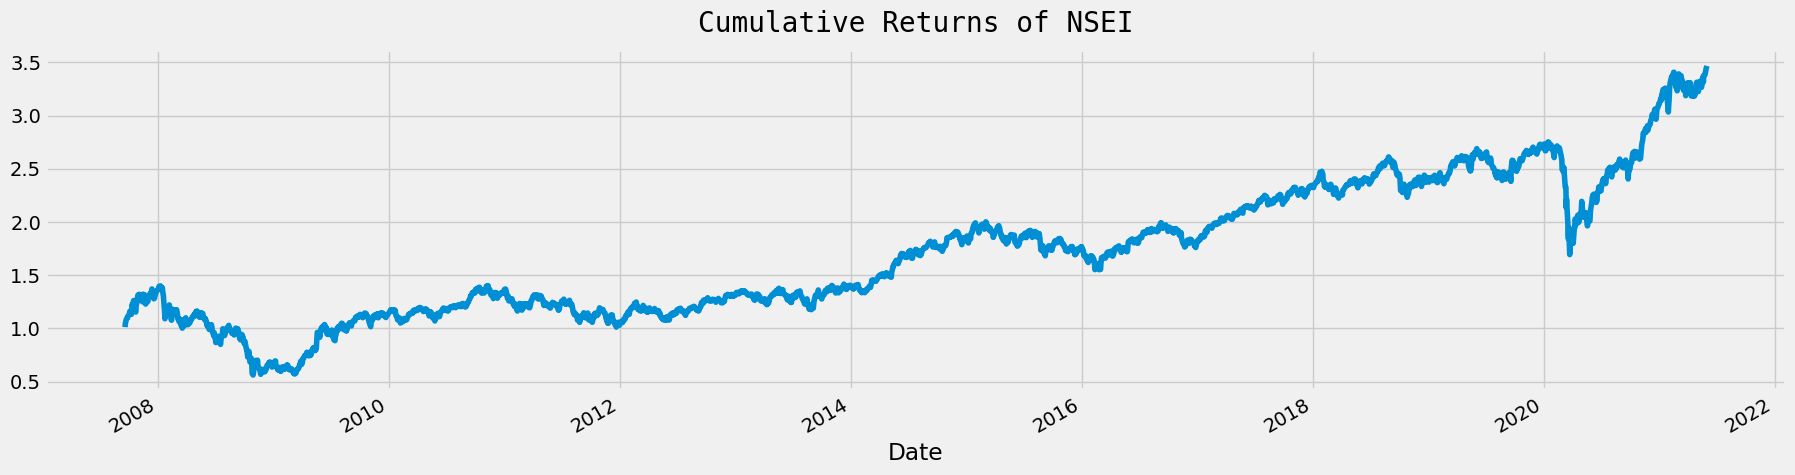

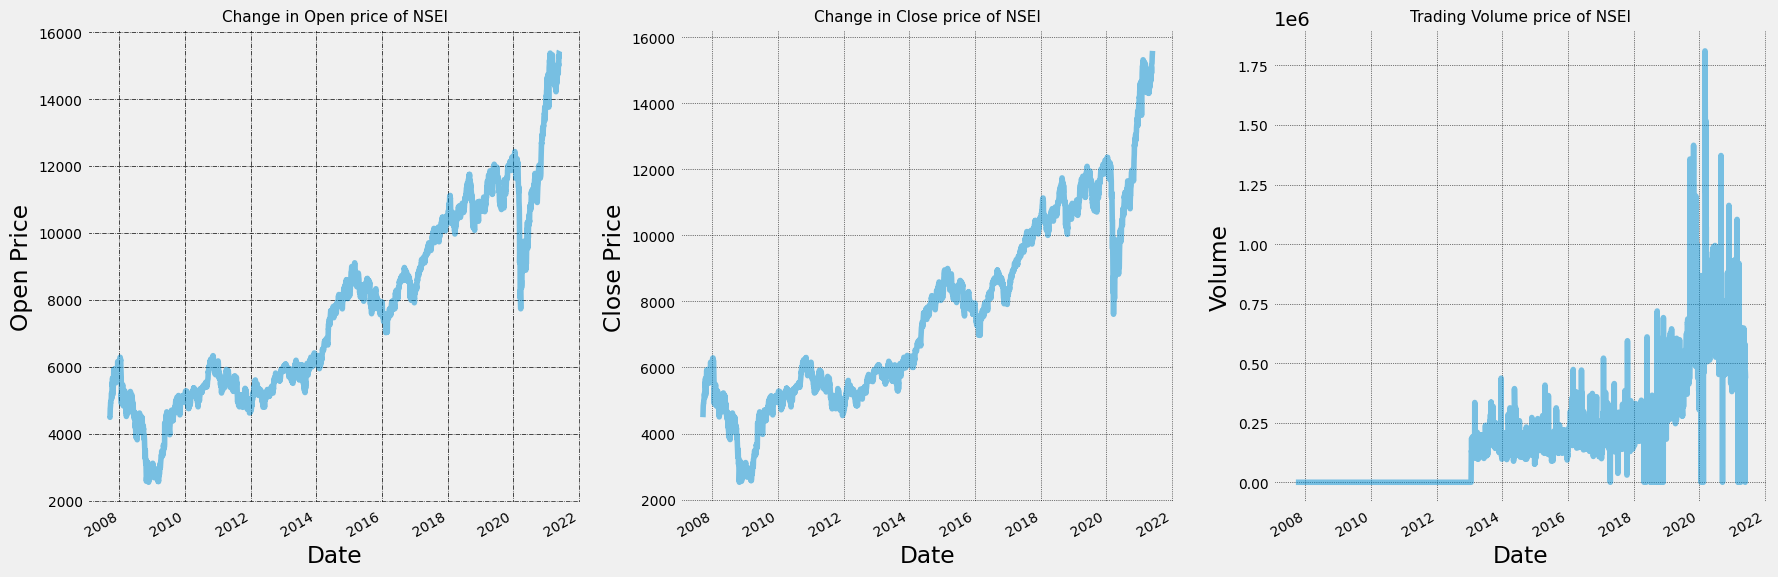

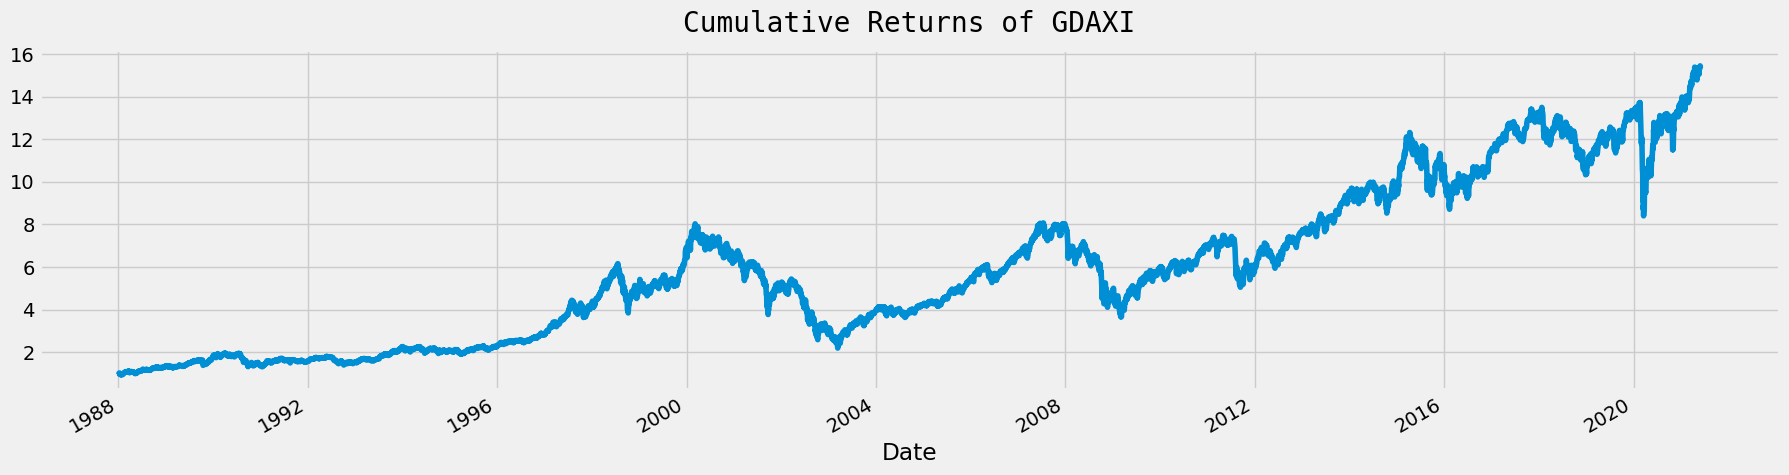

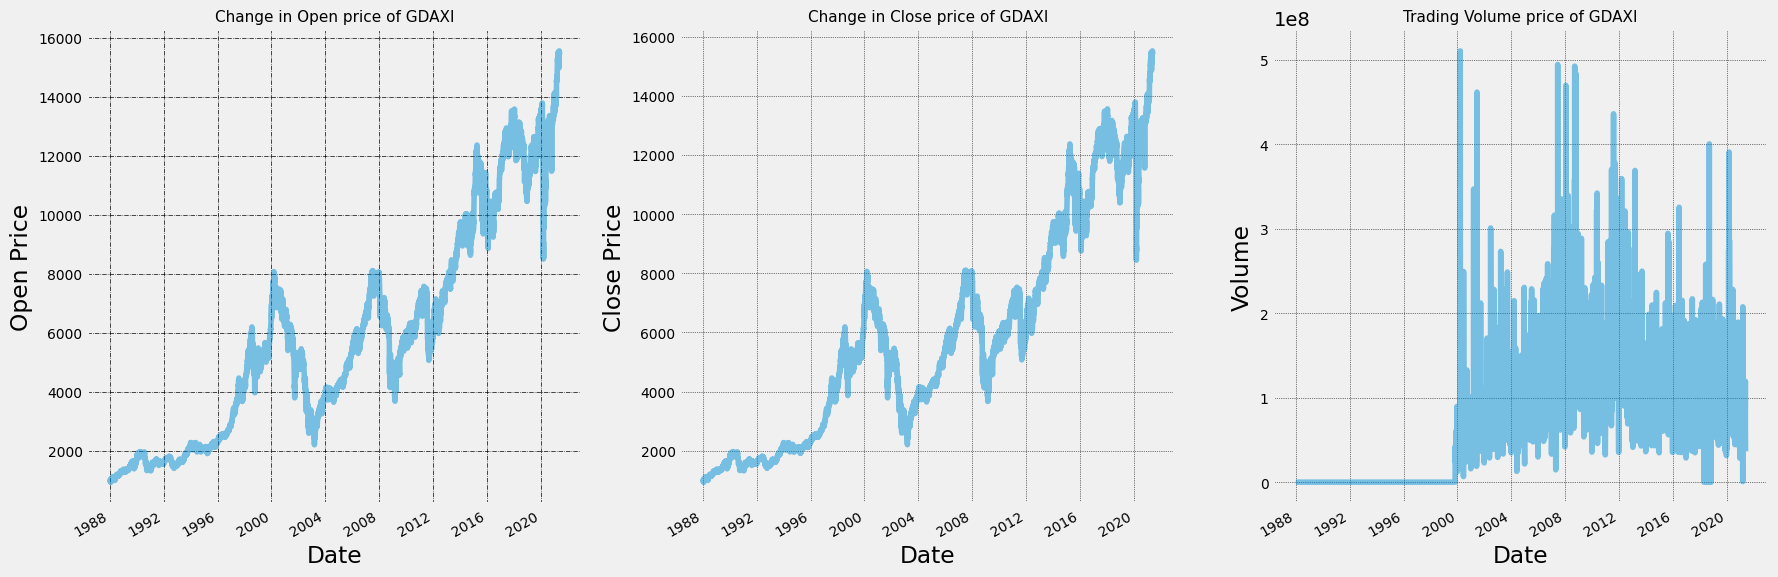

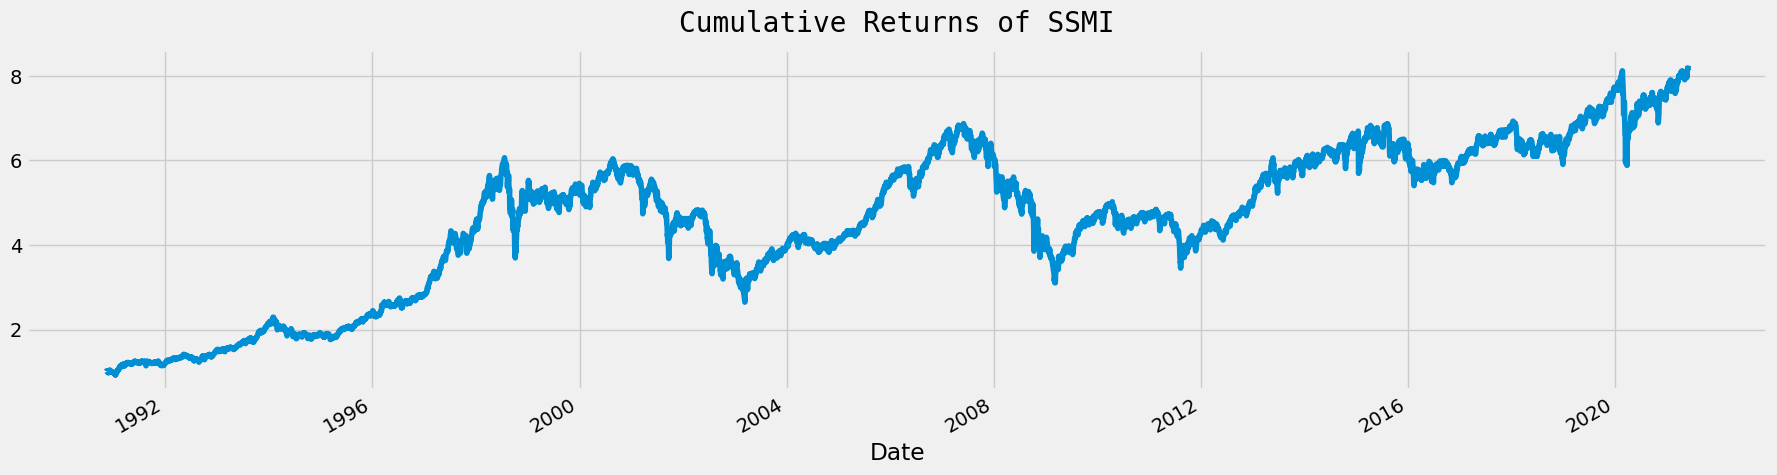

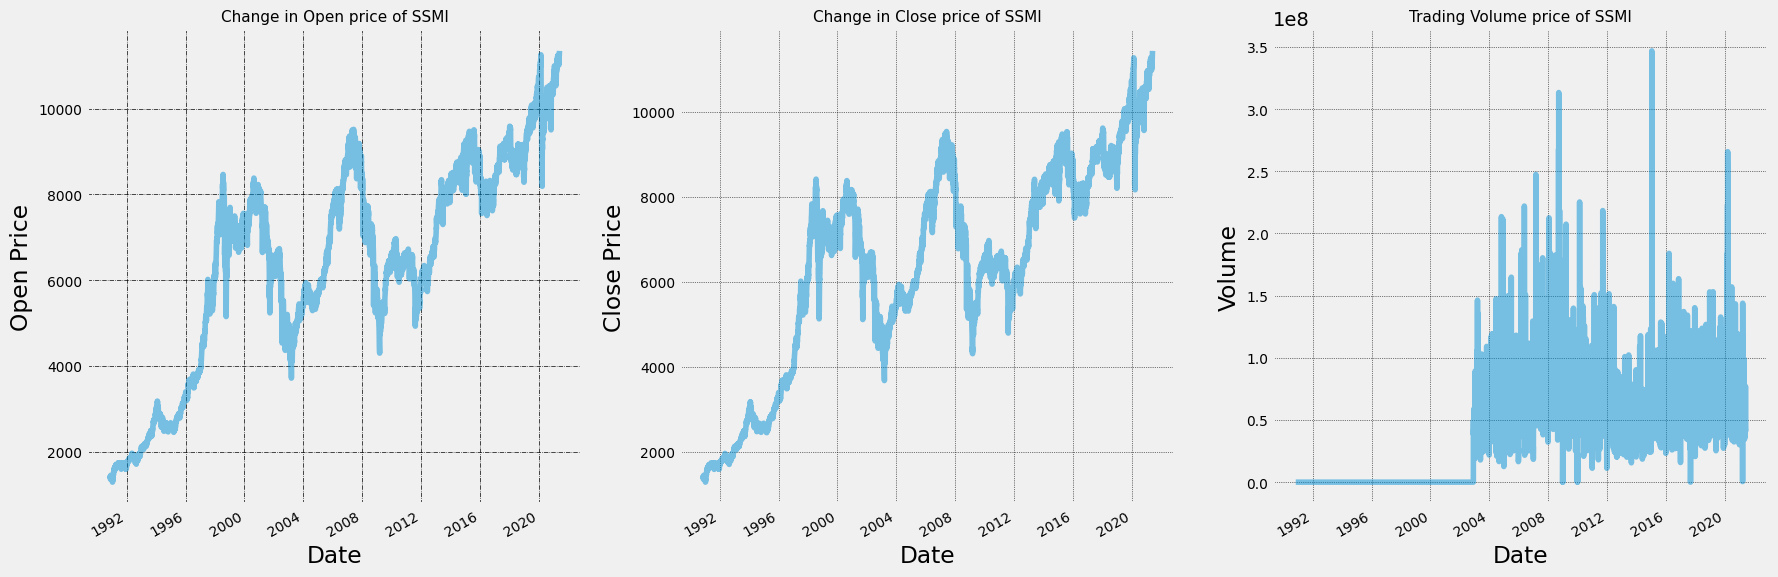

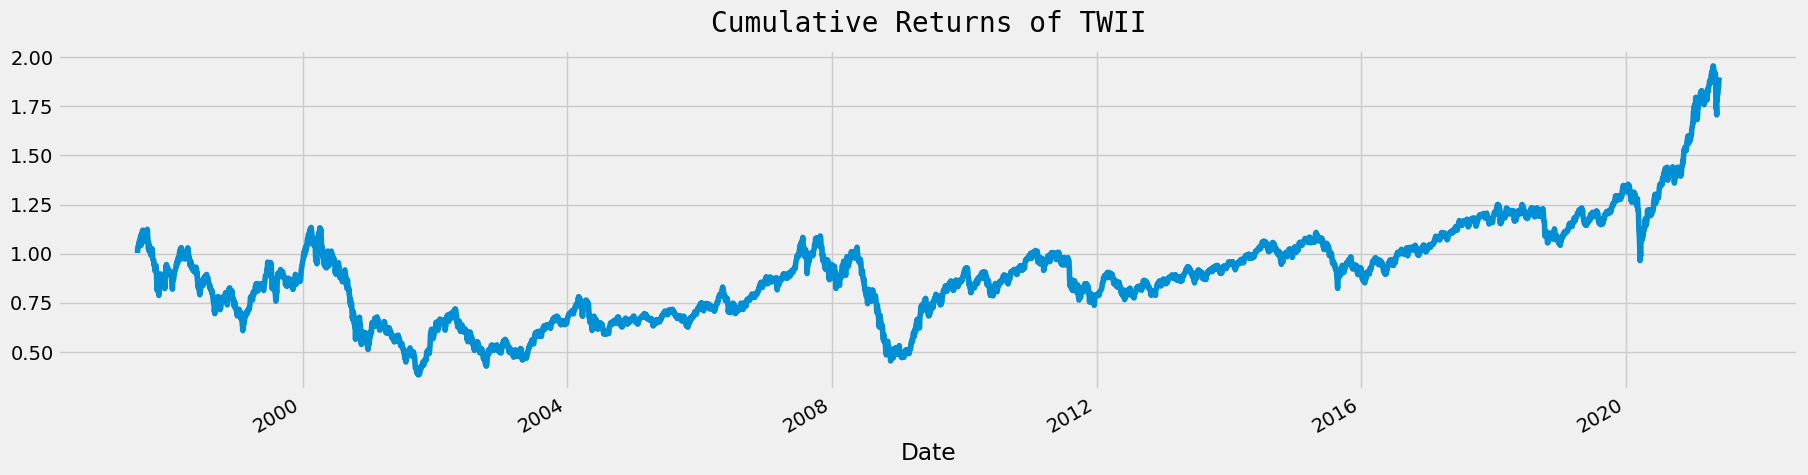

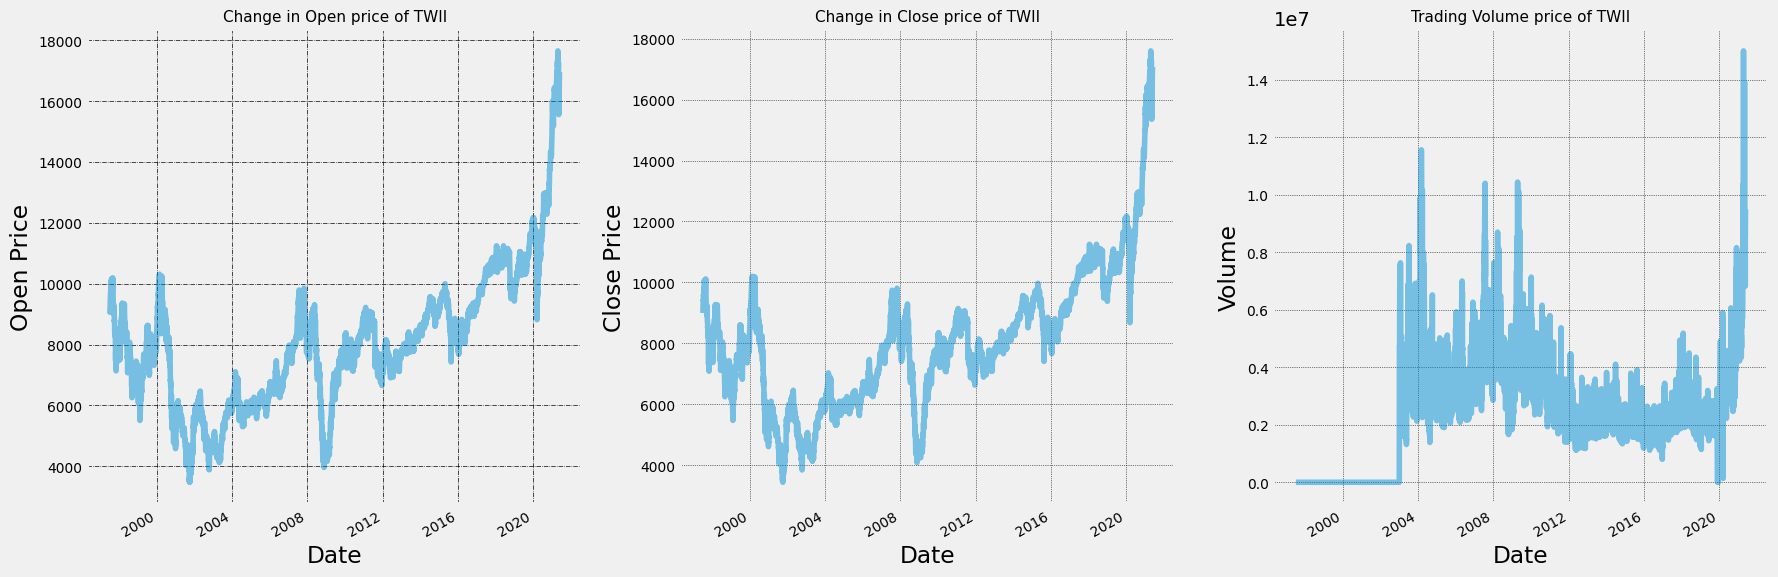

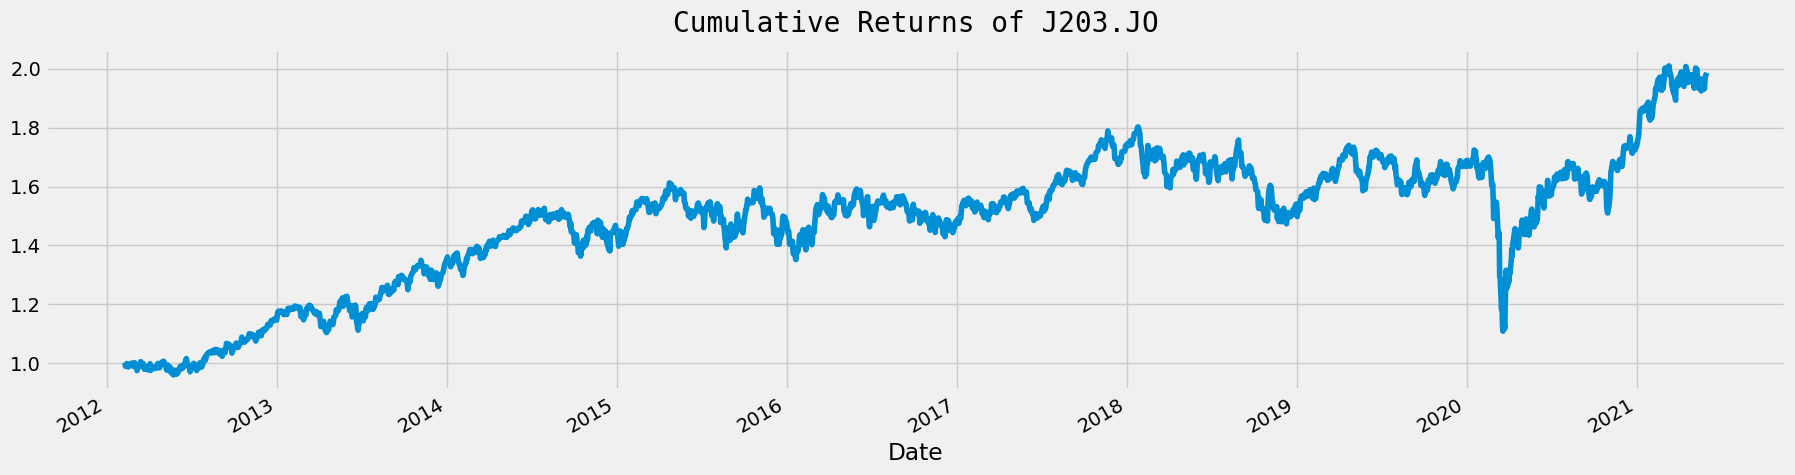

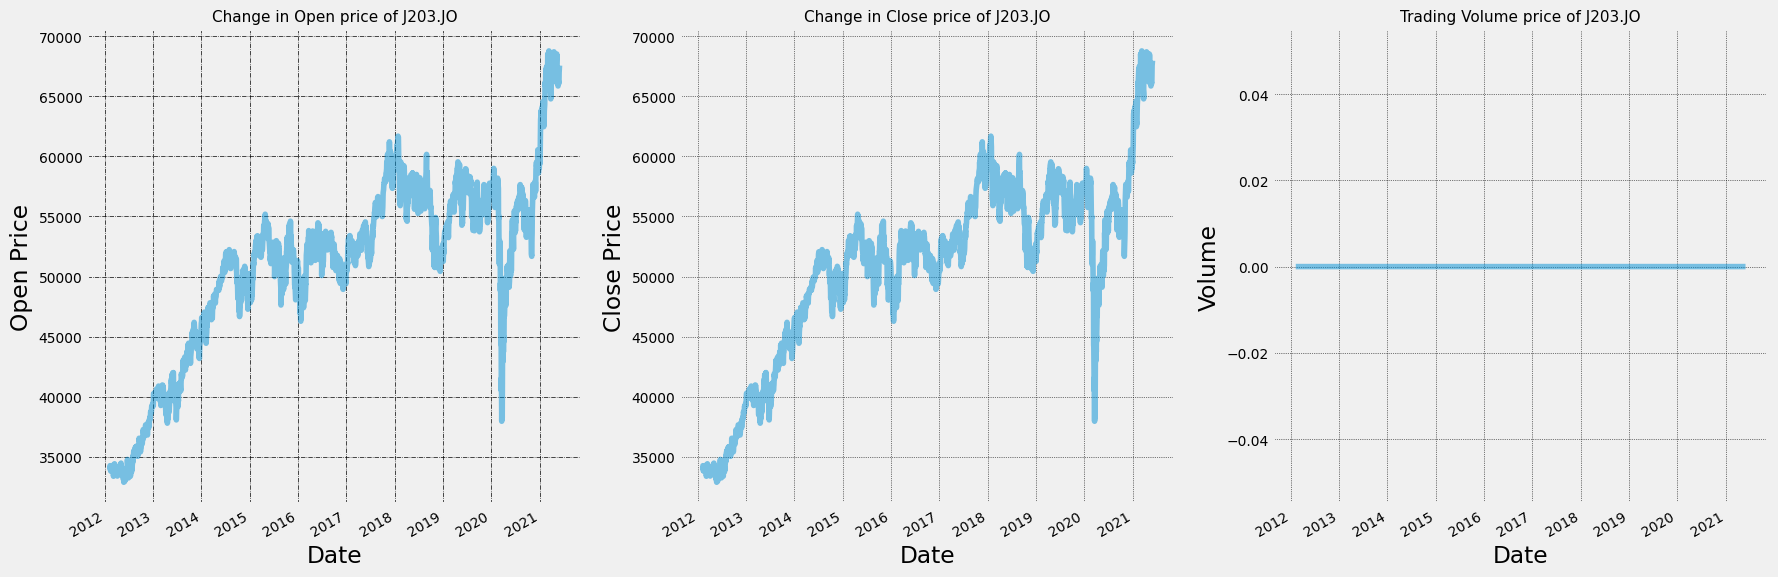

In [ ]:
for exch in df.Index.unique():
    EDA_plots(df,exch)

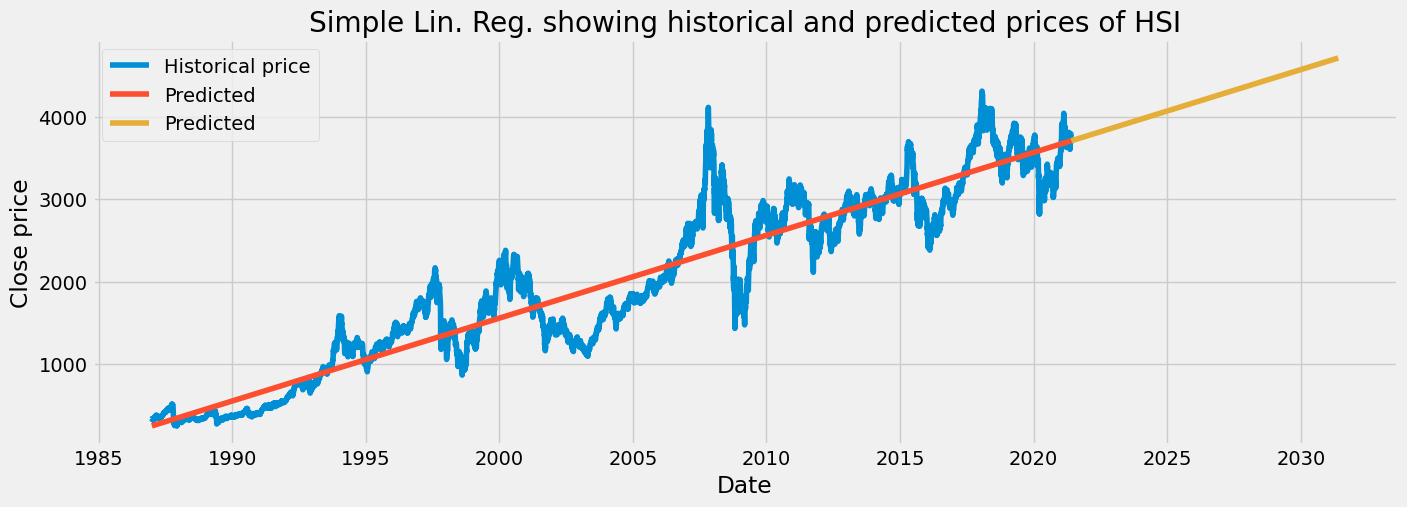

R-squared score HSI : 0.8931274509759525


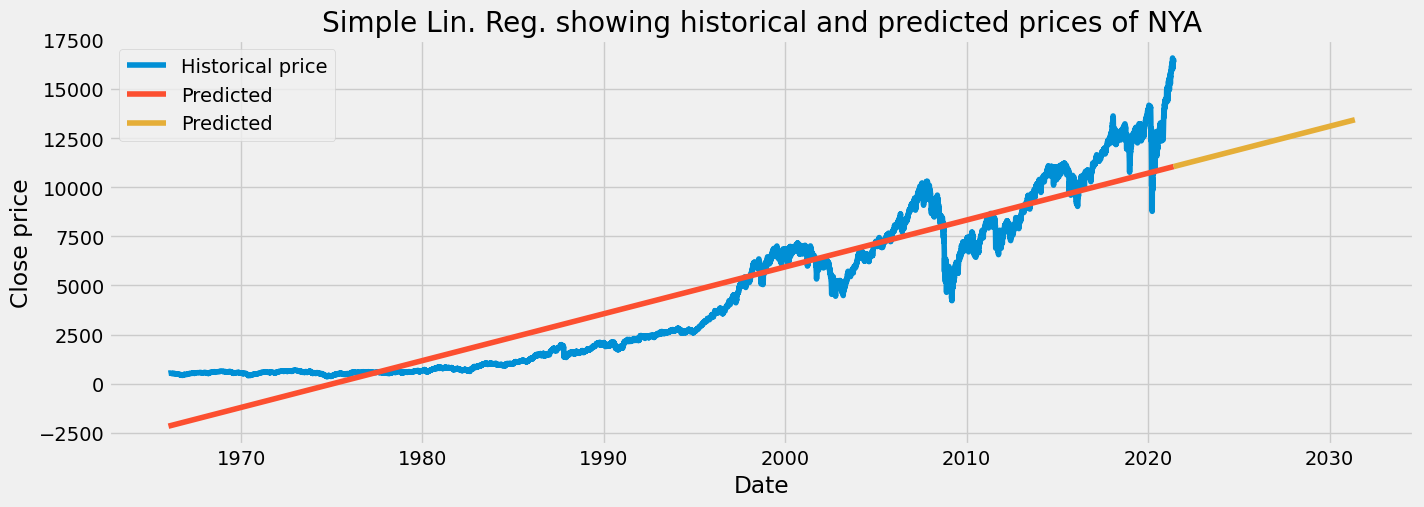

R-squared score NYA : 0.8747463685113148


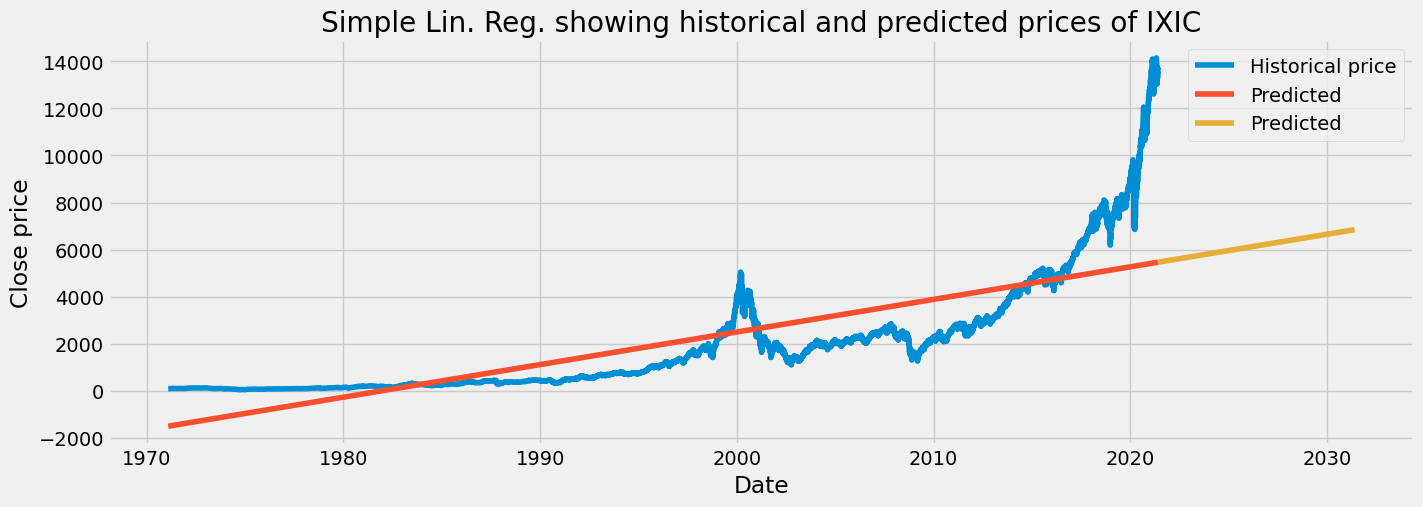

R-squared score IXIC : 0.6501269545473617


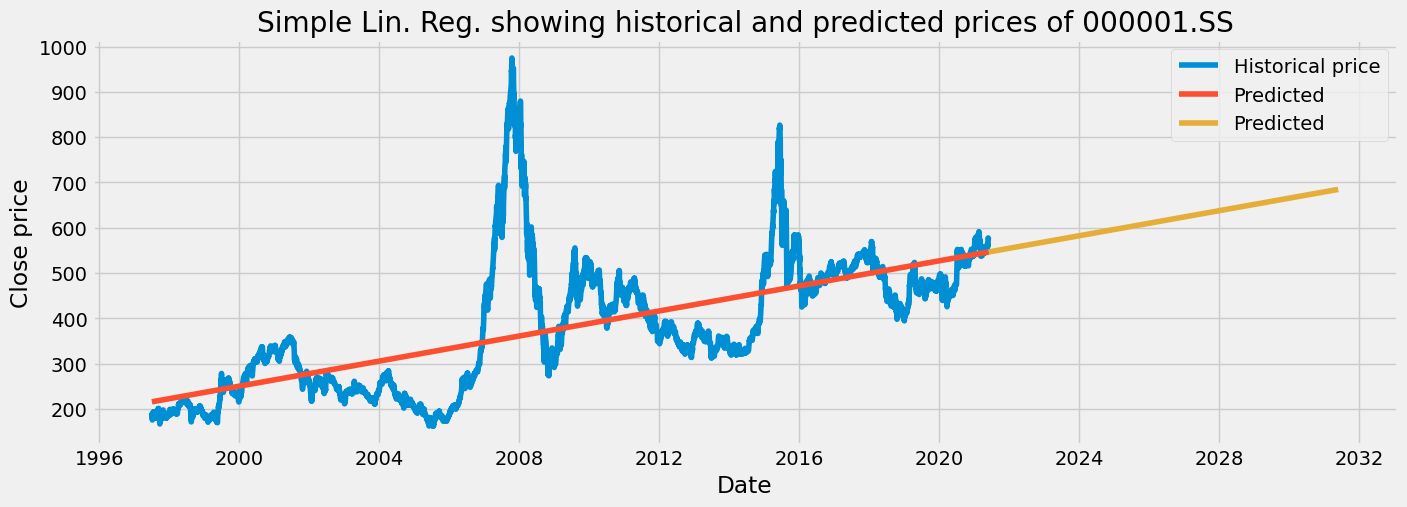

R-squared score 000001.SS : 0.4251333304983649


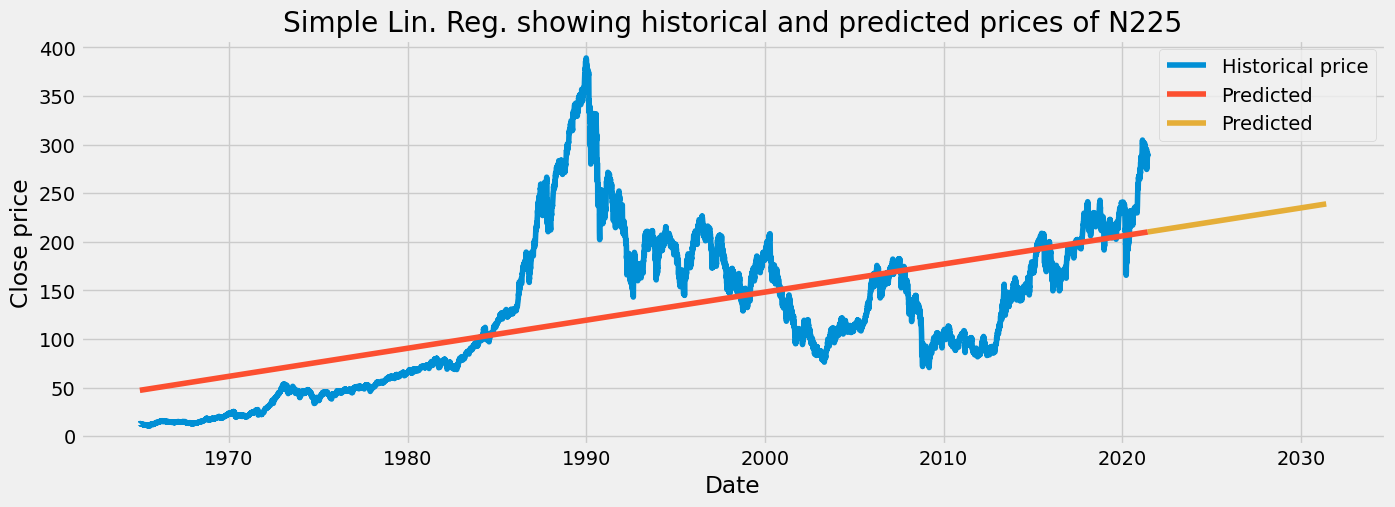

R-squared score N225 : 0.34260595616665335


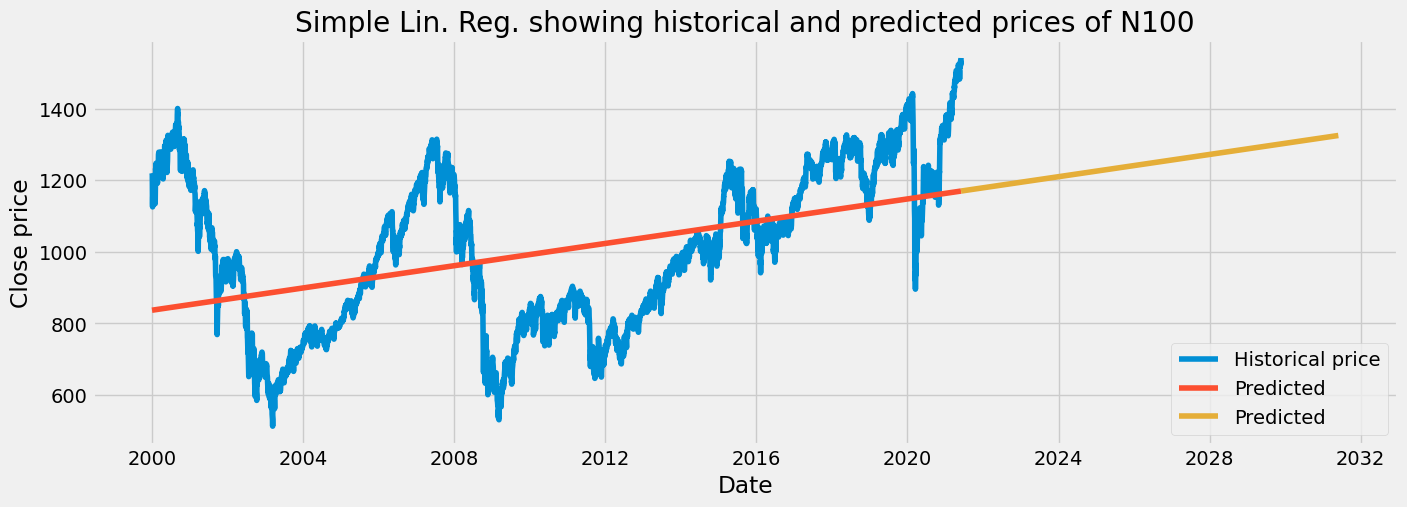

R-squared score N100 : 0.18892847523792788


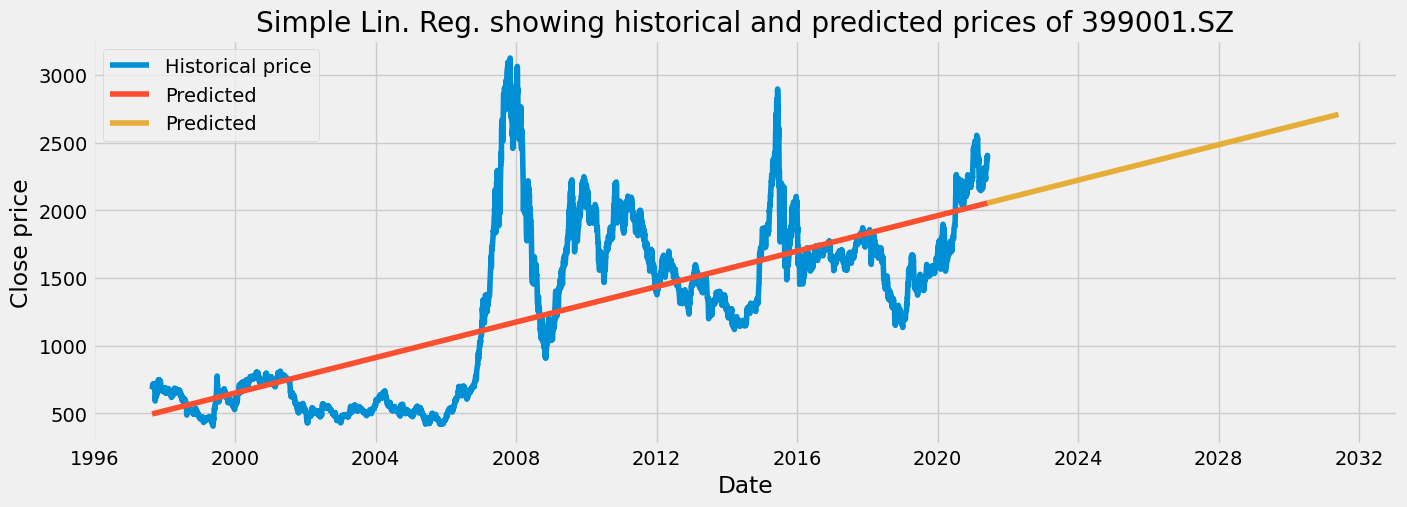

R-squared score 399001.SZ : 0.5027768325832862


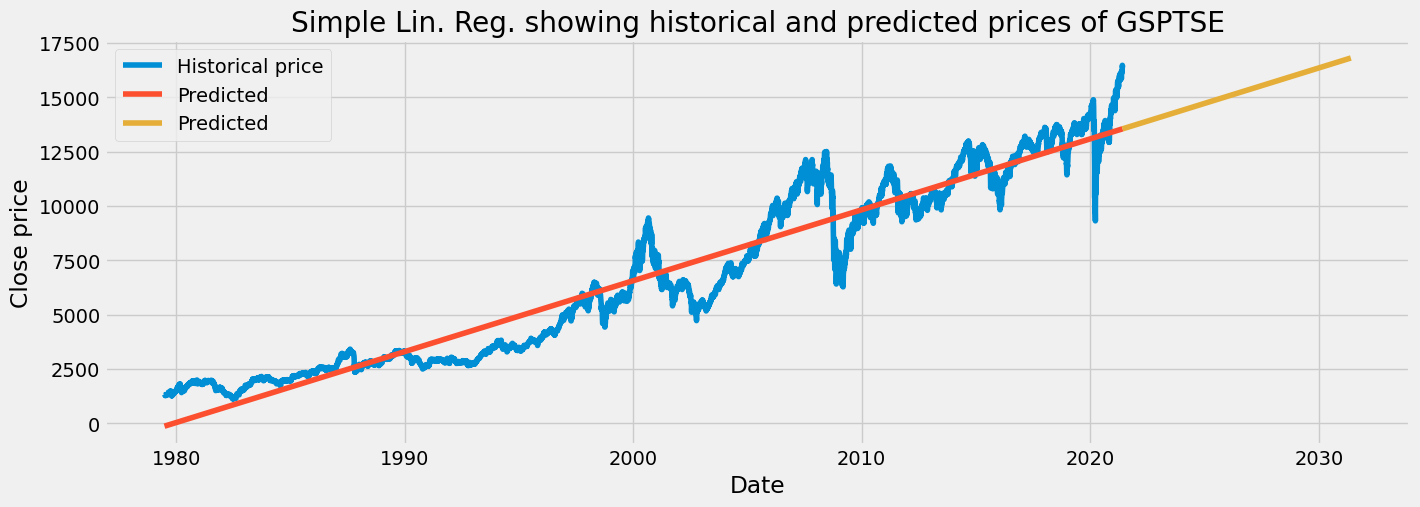

R-squared score GSPTSE : 0.9300651883218196


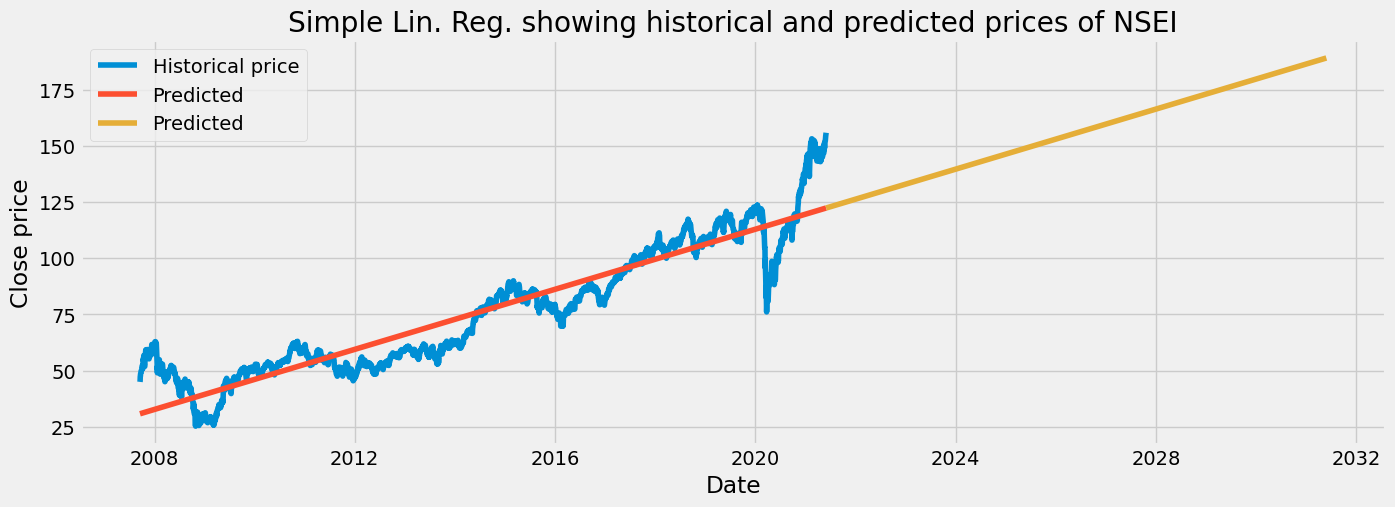

R-squared score NSEI : 0.8716677070743957


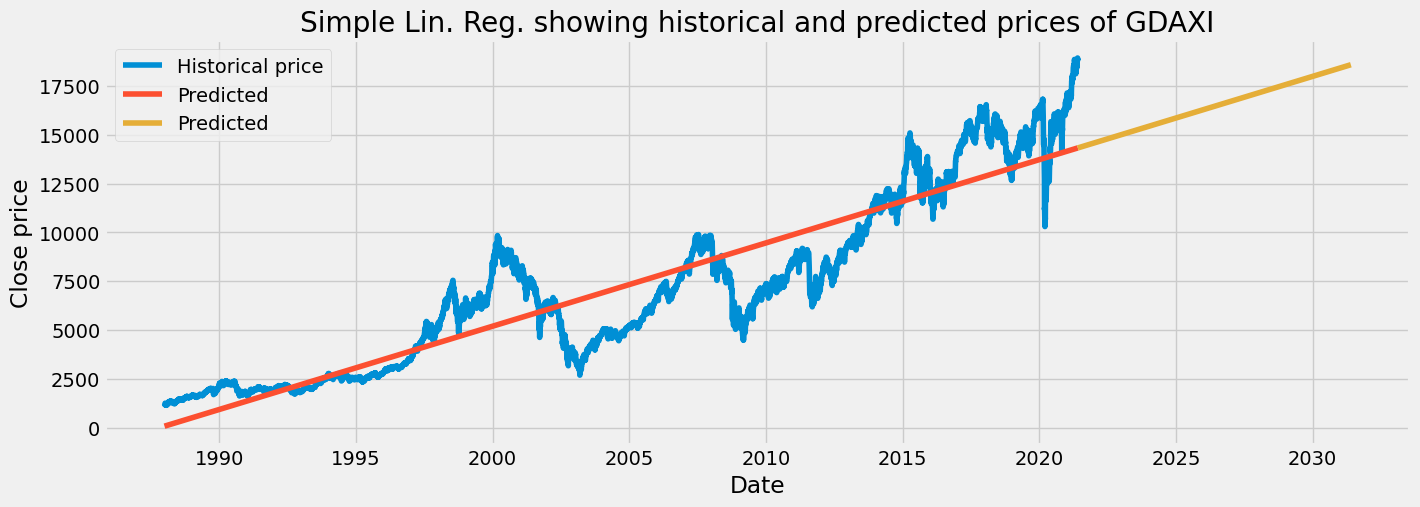

R-squared score GDAXI : 0.8502465344051668


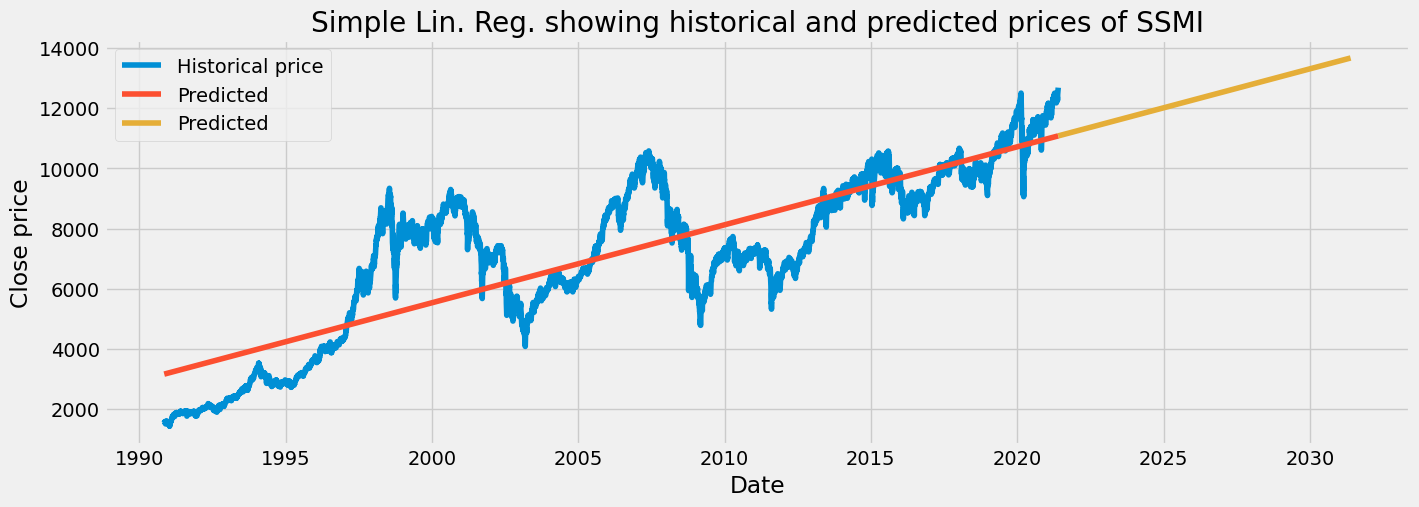

R-squared score SSMI : 0.7090852199974449


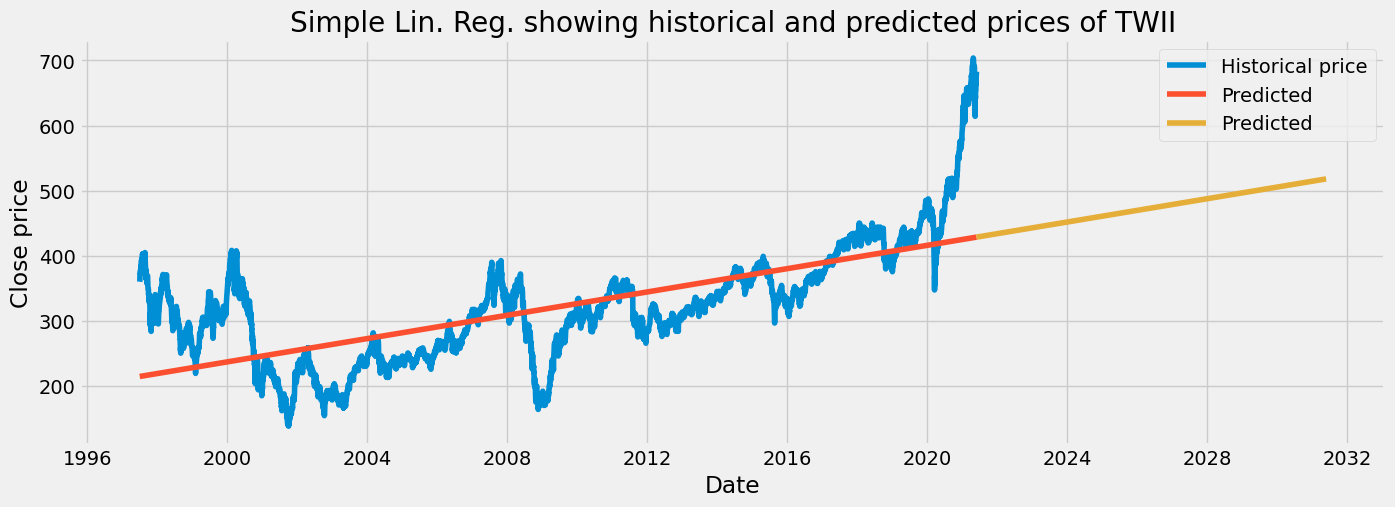

R-squared score TWII : 0.4825164035040662


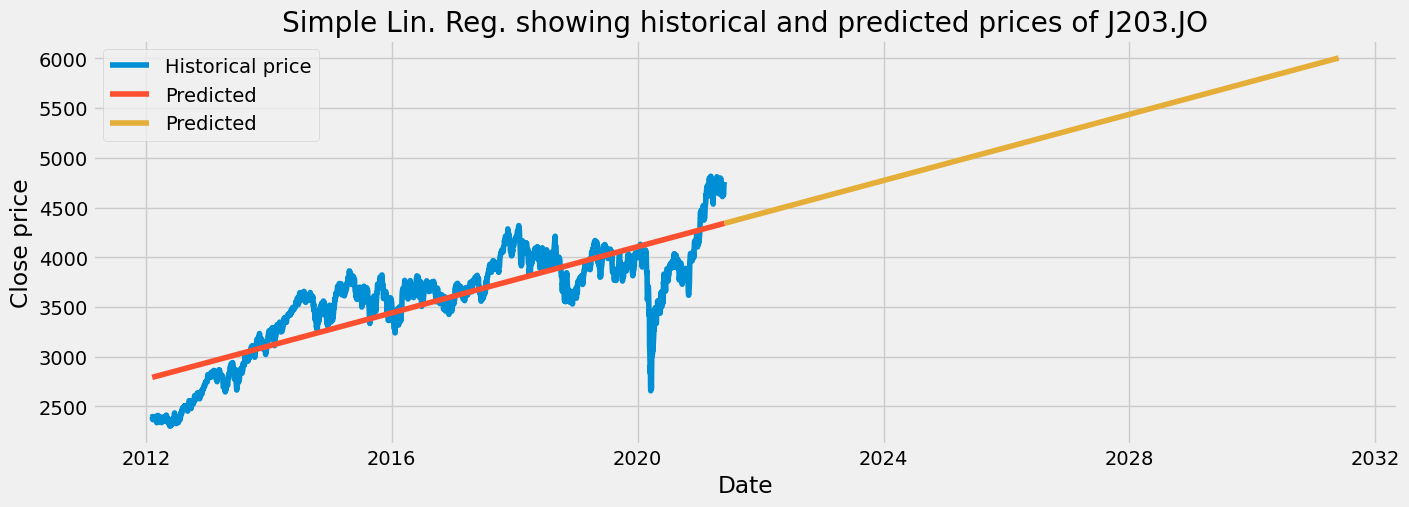

R-squared score J203.JO : 0.704265975352504


In [ ]:
# Simple linear regression function for price prediction

def simple_lr(stcexch):
    data = df.reset_index()
    data = data[data['Index'] == stcexch]
    # x = np.array(data.index).reshape(-1,1)
    # y = data['CloseUSD']

    dfcopy = df.copy()
    dfcopy_nya = dfcopy.loc[dfcopy.Index == stcexch]
    dfcopy_nya.index = (dfcopy_nya.index - pd.to_datetime('1970-01-01')).days


    y = np.asarray(dfcopy_nya['CloseUSD'])
    X = np.asarray(dfcopy_nya.index.values)

    # train the model
    lr = LinearRegression().fit(X.reshape(-1,1),y)
    score = lr.score(X.reshape(-1,1),y)

    # prediction
    y_pred = lr.predict(X.reshape(-1,1))

    # convert days back to dates index for the plots
    x_date = pd.to_datetime(dfcopy_nya.index, origin='1970-01-01', unit='D')

    # FUTURE PREDICTIONS
    # # create future dates. Add 10 years == 3650
    newdate = np.asarray(pd.RangeIndex(start=X[-1], stop=X[-1] + 3650))

    # # convert the newdate to higher degree
    #X_newdate = poly.fit_transform(newdate.reshape(-1,1))

    # prediction
    y_newdate_pred = lr.predict(newdate.reshape(-1,1))

    # convert days back to dates index for the plots
    x_future_date = pd.to_datetime(newdate, origin='1970-01-01', unit='D')

    plt.figure(figsize=(15,5))
    plt.plot(X,y, label='Historical price')
    plt.plot(x_date, y_pred, label='Predicted')
    plt.plot(x_future_date,y_newdate_pred, label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title('Simple Lin. Reg. showing historical and predicted prices of ' + stcexch)
    plt.legend()
    plt.show()
    return score
 

for exch in df.Index.unique():
    score = simple_lr(exch)
    print('R-squared score',(exch),':', score)